# Instancia 1: Región del Biobio

#### Tesis Magister Ingeniería Industrial
#### Autor: Kathyana Pérez

In [1]:
# Cargo de librerias
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta 

from sklearn.preprocessing import StandardScaler,Normalizer

In [2]:
# Carga librerias keras
import os
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# Función para generar prediccion
# Recibe: 
#   - datos: matriz de datos
#   - dias_media: cantidad de días tomados para realizar la predicción
#   - dias_generar: cantidad de días a predecir

def dias_extras(datos,dias_medias=30,dias_generar=20):
    aux = list(datos)           # Variable auxiliar 
    
    # Ciclo para calculo de promedio y predicción
    for dia in np.arange(dias_generar):
        calculo = list(aux[-dias_medias:])               # Calculo promedio
        aux.append(int(np.floor(np.mean(calculo))))      # Se agregan al array los días predichos
    return np.array(aux)

## I. Preprocesamiento Datos

##### Fuentes:
- Pacientes en UCI, Examenes PCR, Cantidad de camas, Defunciones; obtenidas del Github del Ministerio de ciencias, link: https://github.com/MinCiencia/Datos-COVID19


- Cuarentenas, obtenidas de Wikipedia: https://es.m.wikipedia.org/wiki/Confinamiento_por_la_pandemia_de_COVID-19_en_Chile, se obtienen los .csv del archivo 'computo-cuarentenas.IPYNB'

### A. Pacientes en UCI NO SE UTILIZO

In [4]:
# Datos de UCI, producto 8, obtenidos del github del ministerio de ciencias
arch_p8 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto8/UCI.csv' # Carga de link
df_uci = pd.read_csv(arch_p8)       # Lectura de datos
df_uci = df_uci.iloc[10][16:]        # Se selecciona solo la Región del Biobío

#Reordenamiento de los datos
df_uci = df_uci.to_frame().reset_index().rename(columns={'index': 'dates', 10:'hospitalizations'}) 


# Visualización del df_uci (dataframe unidad de cuidados intensivos)
print('Data Frame UCI Biobío\n', df_uci)

Data Frame UCI Biobío
           dates hospitalizations
0    2020-04-14               35
1    2020-04-15               35
2    2020-04-16               30
3    2020-04-17               27
4    2020-04-18               25
..          ...              ...
377  2021-04-26              224
378  2021-04-27              226
379  2021-04-28              221
380  2021-04-29              213
381  2021-04-30              203

[382 rows x 2 columns]


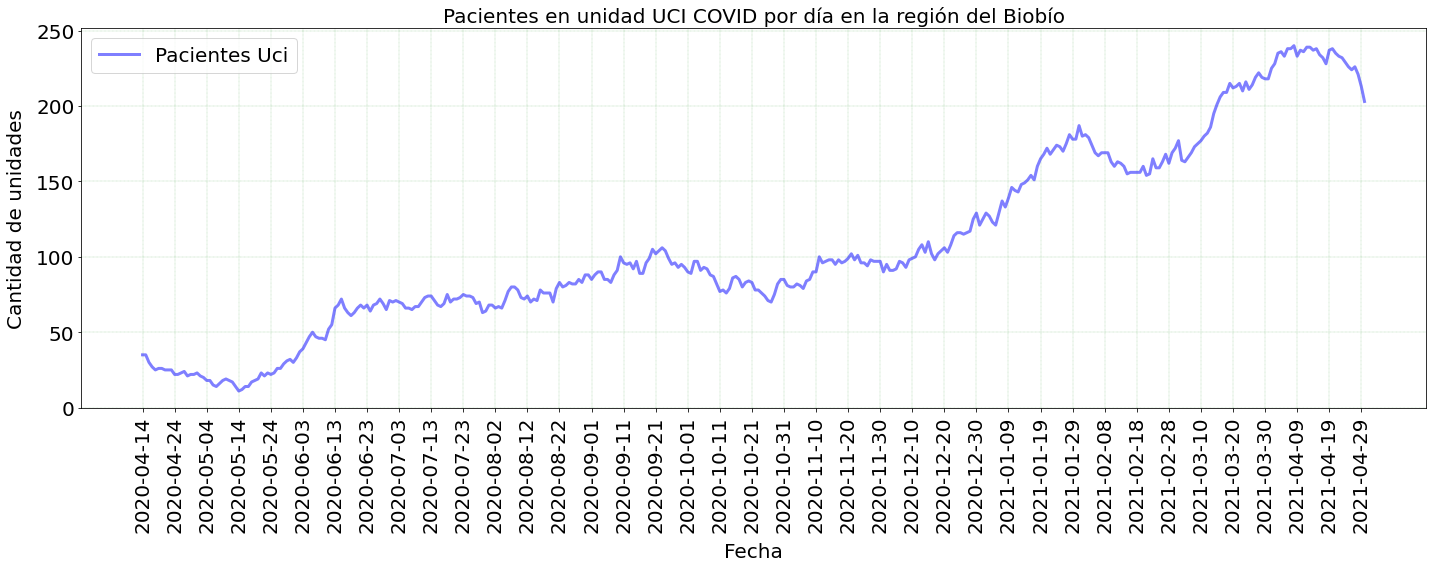

In [5]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.plot(df_uci.dates.values,df_uci.hospitalizations.values,linewidth=3, color = 'blue', alpha = 0.5, label = 'Pacientes Uci')
# plt.axvline(df_uci.dates.values[-1], label = 'Fecha de Hoy',linewidth=3, color = 'red')
plt.xticks(df_uci.dates.index[::10],df_uci.dates.values[::10],rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.grid(color='green', ls = ':', lw = 0.3)
plt.xlabel('Fecha', labelpad = 10, fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('Cantidad de unidades',labelpad = 10,fontsize=20)
plt.title("Pacientes en unidad UCI COVID por día en la región del Biobío",fontsize=20)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\uci_biobio.pdf')

### B. Examenes PCR

In [6]:
# Datos de PCR realizados, producto 7, obtenidos del github del ministerio de ciencias
arch_p7 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto7/PCR.csv" # Carga link
pcr = pd.read_csv(arch_p7)          # Lectura de datos
pcr = pcr.iloc[10][8:]             # Se selecciona solo la Región del Biobío
# pcr = pcr.iloc[10][8:]             # Se selecciona solo la Región del Biobío

#Reordenamiento de los datos
pcr = pcr.to_frame().reset_index().rename(columns={'index': 'fecha', 10:'pcr'})


# # Indice de positividad, producto 55, obtenidos del github del ministerio de ciencias
arch_p55 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto55/Positividad_por_region.csv' # Carga del link
positividad = pd.read_csv(arch_p55)    # Lectura de datos
#                                        # Se selecciona solo la Región del Biobío
positividad = positividad[positividad['Region'] == 'Biobío'].reset_index(drop = True).drop(['Region','Codigo region','region_residencia'], axis=1)
positividad = positividad[43:].reset_index(drop = True)
# positividad = positividad[43:].reset_index(drop = True)

# Visualización de los datos
print('1. Data Frame PCR Biobío\n', pcr)
print('----\n2. Data Frame Positividad Biobío\n', positividad)

1. Data Frame PCR Biobío
           fecha    pcr
0    2020-04-14    218
1    2020-04-15    311
2    2020-04-16    408
3    2020-04-17     80
4    2020-04-18    751
..          ...    ...
377  2021-04-26   7529
378  2021-04-27   4507
379  2021-04-28   2922
380  2021-04-29   5957
381  2021-04-30  11732

[382 rows x 2 columns]
----
2. Data Frame Positividad Biobío
           fecha  positividad
0    2020-04-14     0.046487
1    2020-04-15     0.048032
2    2020-04-16     0.051233
3    2020-04-17     0.051619
4    2020-04-18     0.047357
..          ...          ...
370  2021-04-19     0.095114
371  2021-04-20     0.090886
372  2021-04-21     0.085891
373  2021-04-22     0.082474
374  2021-04-23     0.083005

[375 rows x 2 columns]


In [7]:
# Unir Datos de positividad e info de los PCR
pcr_positivo = pcr.merge(positividad)

# Visualización de los datos
print('Data Frame Resultante Biobío\n', pcr_positivo)

Data Frame Resultante Biobío
           fecha   pcr  positividad
0    2020-04-14   218     0.046487
1    2020-04-15   311     0.048032
2    2020-04-16   408     0.051233
3    2020-04-17    80     0.051619
4    2020-04-18   751     0.047357
..          ...   ...          ...
370  2021-04-19  8670     0.095114
371  2021-04-20  5579     0.090886
372  2021-04-21  4092     0.085891
373  2021-04-22  7973     0.082474
374  2021-04-23  8756     0.083005

[375 rows x 3 columns]


---
Ya que se tienen los dos DataFrame, se calcula la cantidad de positivos mediante una regla de 3 simples:


\begin{equation}  PCR _{positivos}  = PCR_{total} * \textit{Indice de positividad} \end{equation}

---

In [8]:
#  Calculo de PCR positivos
pcr_positivo["positivos"] = pcr_positivo["pcr"] * pcr_positivo["positividad"]

# Los valores Nan de la columna pcr_positivo["positivos"] seran '0', al igual que los valores Nan de la columna de los 
# pcr_positivo["pcr"]
pcr_positivo["positivos"] = pcr_positivo["positivos"].fillna(0).astype(int)
pcr_positivo["pcr"] = pcr_positivo["pcr"].fillna(0).astype(int)

# Visualización de los datos del DataFrame resultante
print('Data Frame Resultante Biobío\n', pcr_positivo)

Data Frame Resultante Biobío
           fecha   pcr  positividad  positivos
0    2020-04-14   218     0.046487         10
1    2020-04-15   311     0.048032         14
2    2020-04-16   408     0.051233         20
3    2020-04-17    80     0.051619          4
4    2020-04-18   751     0.047357         35
..          ...   ...          ...        ...
370  2021-04-19  8670     0.095114        824
371  2021-04-20  5579     0.090886        507
372  2021-04-21  4092     0.085891        351
373  2021-04-22  7973     0.082474        657
374  2021-04-23  8756     0.083005        726

[375 rows x 4 columns]


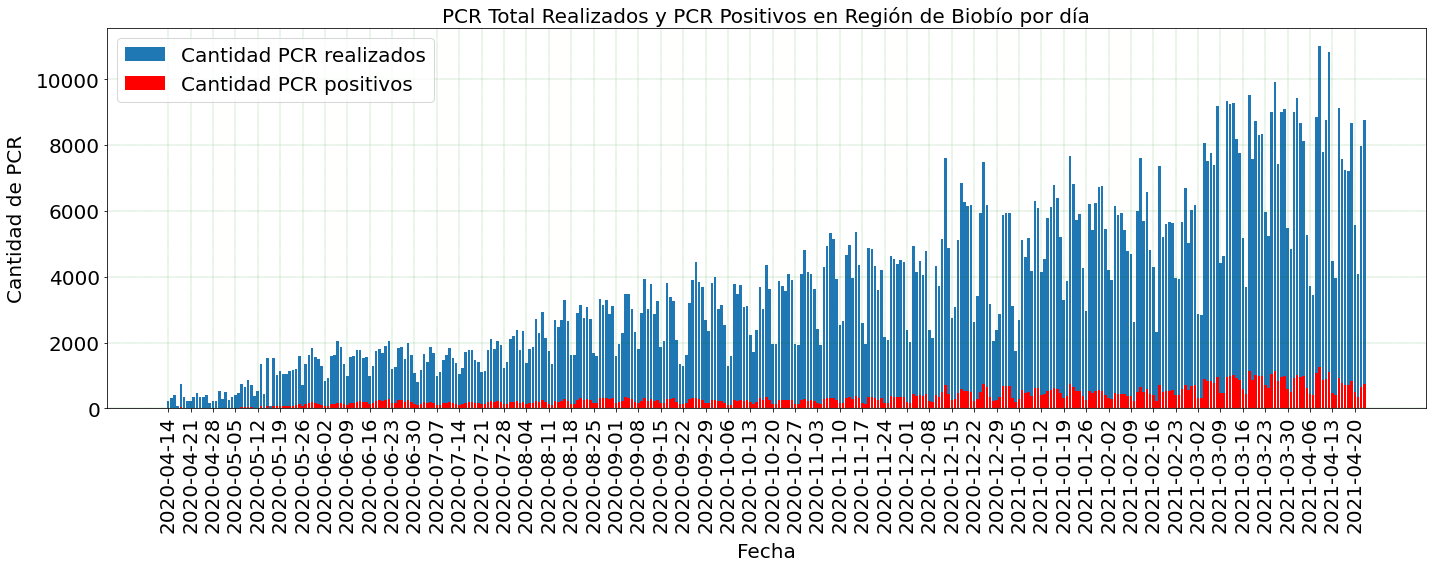

In [9]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.bar(pcr_positivo['fecha'], pcr_positivo['pcr'], label = 'Cantidad PCR realizados')
plt.bar(pcr_positivo['fecha'], pcr_positivo['positivos'], label = 'Cantidad PCR positivos', color = 'red')
plt.xticks(pcr_positivo['fecha'][::7],rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(color='green', ls = ':', lw = 0.4)
plt.xlabel('Fecha',  labelpad = 10, fontsize = 20)
plt.ylabel('Cantidad de PCR',labelpad = 10, fontsize = 20)
plt.title('PCR Total Realizados y PCR Positivos en Región de Biobío por día', fontsize = 20)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\pcr_biobio.pdf')

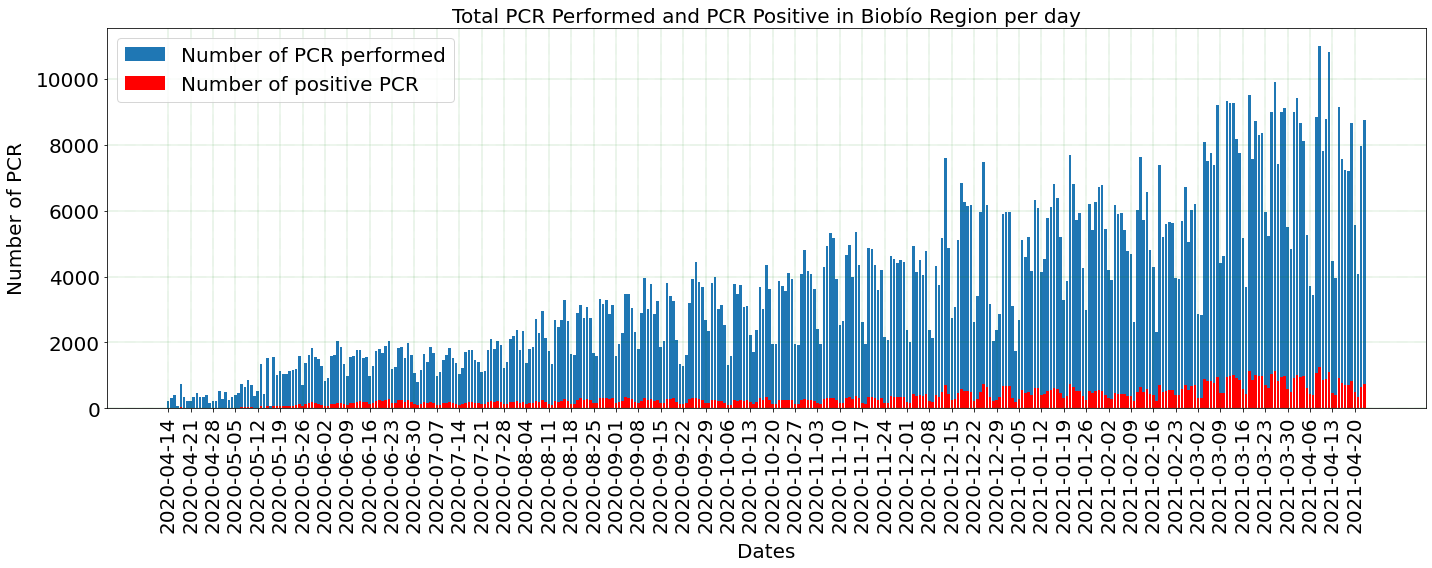

In [10]:
# Grafico imagen Ingles
plt.figure(figsize=(20,8))
plt.bar(pcr_positivo['fecha'], pcr_positivo['pcr'], label = 'Number of PCR performed')
plt.bar(pcr_positivo['fecha'], pcr_positivo['positivos'], label = 'Number of positive PCR', color = 'red')
plt.xticks(pcr_positivo['fecha'][::7],rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(color='green', ls = ':', lw = 0.4)
plt.xlabel('Dates',  labelpad = 10, fontsize = 20)
plt.ylabel('Number of PCR',labelpad = 10, fontsize = 20)
plt.title('Total PCR Performed and PCR Positive in Biobío Region per day', fontsize = 20)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\paper\pcr_ingles_biobio.pdf')

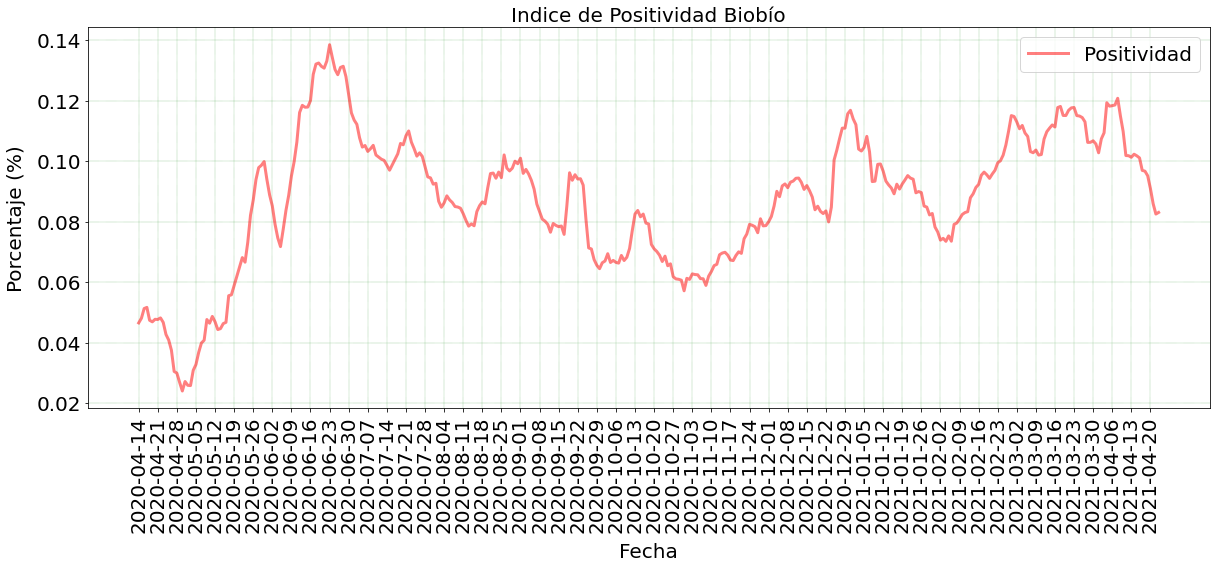

In [11]:
# Grafico positividad
plt.figure(figsize=(17,8))
plt.plot(pcr_positivo['fecha'], pcr_positivo['positividad'],color = 'red', linewidth = 3, alpha = 0.5, label = 'Positividad')
plt.xticks(pcr_positivo['fecha'][::7],rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(color='green', ls = ':', lw = 0.4)
plt.legend(fontsize = 20)
plt.xlabel('Fecha',  labelpad = 10, fontsize = 20)
plt.ylabel('Porcentaje (%)', labelpad = 10, fontsize = 20)
plt.title('Indice de Positividad Biobío', fontsize = 20)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\positividad_biobio.pdf')

### C. Camas Disponibles

In [12]:
# Datos de Camas UCI, producto 58, obtenidos del github del ministerio de ciencias
arch_p58 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto58/Camas_UCI_diarias.csv" # Carga link
camas = pd.read_csv(arch_p58)         # Lectura de datos

fin = 349
# Se selecciona solo la Región del Biobío 
camas_disponibles = camas.iloc[10][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 10:'total disponibles'})
camas_covid       = camas.iloc[27][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 27:'camas ocupadas covid'}) # Biobio
camas_no_covid    = camas.iloc[44][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 44:'camas ocupadas no covid'})# Biobio
camas_ocupadas    = camas.iloc[61][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 61:'total camas ocupadas'})

# # Visualización de los datos del DataFrame resultante
print('1. Camas UCI utilizadas por pacientes COVID-19 Biobío\n', camas_covid)
print('\n2. Camas UCI utilizadas por pacientes no COVID-19 Biobío\n', camas_no_covid)
print('\n3. Camas UCI disponibles Biobío\n', camas_disponibles)
print('\n4. Camas UCI total ocupadas Biobío\n', camas_ocupadas)


1. Camas UCI utilizadas por pacientes COVID-19 Biobío
           fecha camas ocupadas covid
0    2020-04-14                   35
1    2020-04-15                   30
2    2020-04-16                   27
3    2020-04-17                   25
4    2020-04-18                   26
..          ...                  ...
374  2021-04-23                  232
375  2021-04-24                  229
376  2021-04-25                  226
377  2021-04-26                  224
378  2021-04-27                  226

[379 rows x 2 columns]

2. Camas UCI utilizadas por pacientes no COVID-19 Biobío
           fecha camas ocupadas no covid
0    2020-04-14                      55
1    2020-04-15                      52
2    2020-04-16                      52
3    2020-04-17                      58
4    2020-04-18                      56
..          ...                     ...
374  2021-04-23                      64
375  2021-04-24                      65
376  2021-04-25                      67
377  2021-04-26   

In [13]:
# Para informe
camas1       = pd.concat([camas_disponibles['fecha'],camas_covid['camas ocupadas covid'],camas_no_covid['camas ocupadas no covid'],camas_disponibles['total disponibles']], axis=1, join="inner")
camas_quedan = camas1['total disponibles'] - (camas1['camas ocupadas covid'] + camas1['camas ocupadas no covid'])
camas2       = pd.concat([camas1, camas_quedan], axis=1, join="inner")
camas2       = camas2.rename(columns={'camas ocupadas covid': 'Covid','camas ocupadas no covid': 'no Covid',
                                      0: 'Disponibles','total disponibles':'Camas Habilitadas'})
print(camas2)

          fecha Covid no Covid Camas Habilitadas Disponibles
0    2020-04-14    35       55               125          35
1    2020-04-15    30       52               133          51
2    2020-04-16    27       52               140          61
3    2020-04-17    25       58               141          58
4    2020-04-18    26       56               141          59
..          ...   ...      ...               ...         ...
374  2021-04-23   232       64               313          17
375  2021-04-24   229       65               313          19
376  2021-04-25   226       67               315          22
377  2021-04-26   224       65               315          26
378  2021-04-27   226       66               315          23

[379 rows x 5 columns]


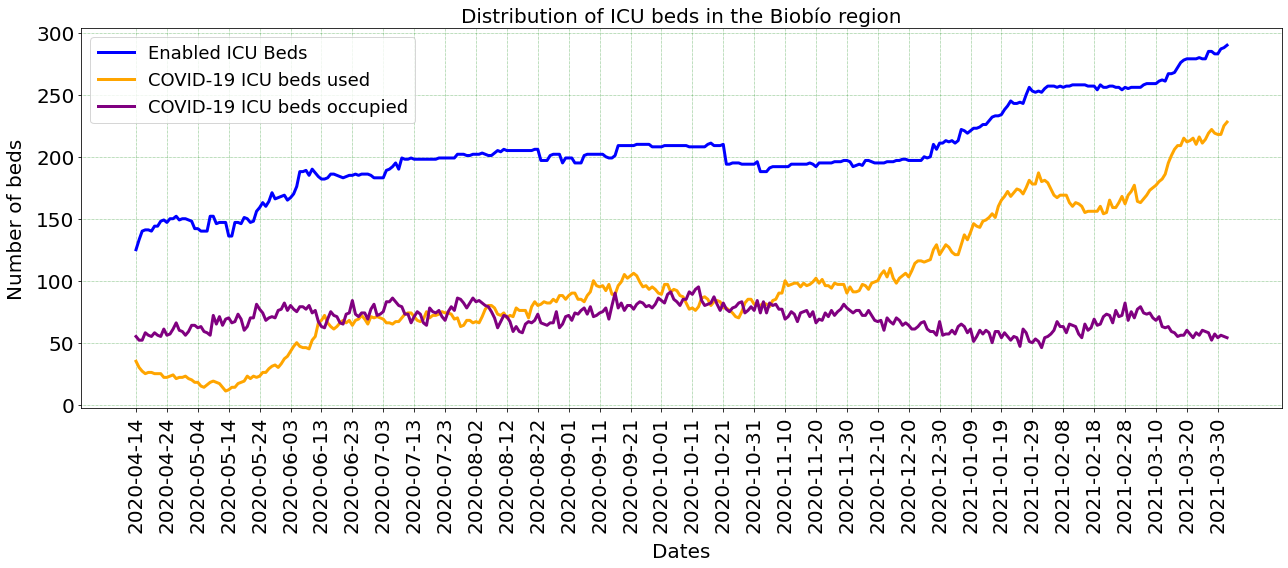

In [14]:
# Grafico imagen
plt.figure(figsize=(18,8))
plt.plot(camas_disponibles['fecha'].values[:354] , camas_disponibles['total disponibles'].values[:354],label = "Enabled ICU Beds",linewidth = 3, color = 'blue')
plt.plot(camas_covid['fecha'].values[:354] , camas_covid['camas ocupadas covid'].values[:354],label ='COVID-19 ICU beds used',linewidth = 3, color = 'orange')
plt.plot(camas_no_covid['fecha'].values[:354] , camas_no_covid['camas ocupadas no covid'].values[:354],label ='COVID-19 ICU beds occupied',linewidth = 3, color = 'purple')
plt.xticks(camas_disponibles['fecha'].values[:354:10],rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(color='green', ls = ':', lw = 0.5)
plt.legend(fontsize = 18)
plt.xlabel('Dates', labelpad = 10, fontsize = 20)
plt.ylabel('Number of beds',labelpad = 10,fontsize = 20)
plt.title('Distribution of ICU beds in the Biobío region', fontsize = 20)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\camas_ingles_biobio.pdf')

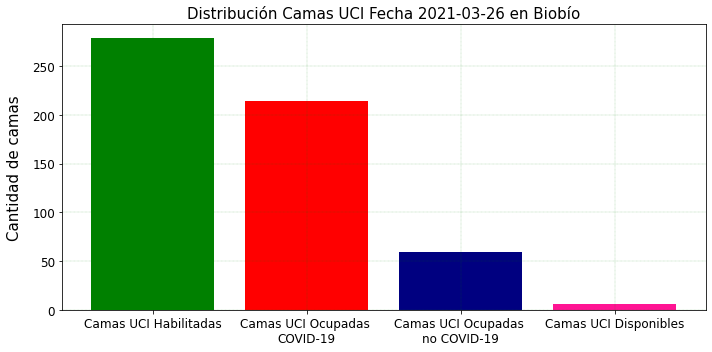

In [15]:
# Grafico Barras Camas
plt.figure(figsize=(10,5))
plt.bar('Camas UCI Habilitadas',camas2['Camas Habilitadas'].values[346], color ='green')
plt.bar('Camas UCI Ocupadas \nCOVID-19', camas_covid['camas ocupadas covid'].values[346], color = 'red')
plt.bar('Camas UCI Ocupadas \nno COVID-19', camas_no_covid['camas ocupadas no covid'].values[346], color = 'navy')
plt.bar('Camas UCI Disponibles',camas2['Disponibles'].values[346],color ='deeppink')

plt.grid(color='green', ls = ':', lw = 0.3)
plt.xlabel('', labelpad = 10, fontsize = 15)
plt.ylabel('Cantidad de camas', labelpad = 10,fontsize = 15)
plt.xticks (fontsize = 12)
plt.yticks (fontsize = 12)
plt.title('Distribución Camas UCI Fecha %s en Biobío' %camas_ocupadas['fecha'].values[346],fontsize = 15)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\camas_bar_biobio.pdf')

### D. Fallecidos 

In [16]:
# Datos de Defunciones, producto 14, obtenidos del github del ministerio de ciencias
arch_p14 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo.csv' #Carga Link
defunciones = pd.read_csv(arch_p14) # Lectura de datos
df_fallecidos = defunciones[defunciones['Region'] == 'Biobío'].reset_index(drop=True).drop(['Region'], axis=1)
abril_14 = np.argwhere(df_fallecidos.T.index.values=="2020-04-14")[0][0]
# df_fallecidos = df_fallecidos[df_fallecidos.columns[abril_14:370]]
df_fallecidos = df_fallecidos[df_fallecidos.columns[abril_14:]]
#Visualización
print('Fallecidos Acumulativos\n', df_fallecidos.T)

Fallecidos Acumulativos
                  0
2020-04-14     2.0
2020-04-15     2.0
2020-04-16     2.0
2020-04-17     3.0
2020-04-18     3.0
...            ...
2021-04-25  1842.0
2021-04-26  1854.0
2021-04-27  1854.0
2021-04-28  1854.0
2021-04-29  1866.0

[381 rows x 1 columns]


In [17]:
# Ya que el DataFrame contiene los casos acumulados se debe calcular los casos diarios, mediante la resta entre el día actual 
# menos el día anterior.

fallecidos = df_fallecidos.values[0]            # Se copian los datos de los fallecidos acumulativos por día
resultados = fallecidos[1:]-fallecidos[:-1]     # Resta de los días actuales - día anterior
resultados[resultados<0] = 0                    # En el caso que exista un valor negativo se hace 0
resultados = list(resultados)                   # Se transforman los datos a una lista
resultados.insert(0,0)                          # Insertamos los datos del primer día, ya que es el unico dato que no
                                                # se calcula como el anterior
fallecidos = pd.DataFrame()                     # Creacion del DataFrame que contendra los datos
fallecidos["fechas"] = df_fallecidos.columns    # Asignacion de fechas al nuevo DataFrame
fallecidos["fallecidos"] = np.array(resultados) # Asignacion de cantidad de fallecidos nuevo DataFrame

# Para grafica
df_fallecidos = df_fallecidos.T.reset_index().rename(columns={'index': 'fecha', 0:'total acumulados'})

# Visualización
print(fallecidos)

         fechas  fallecidos
0    2020-04-14         0.0
1    2020-04-15         0.0
2    2020-04-16         0.0
3    2020-04-17         1.0
4    2020-04-18         0.0
..          ...         ...
376  2021-04-25         8.0
377  2021-04-26        12.0
378  2021-04-27         0.0
379  2021-04-28         0.0
380  2021-04-29        12.0

[381 rows x 2 columns]


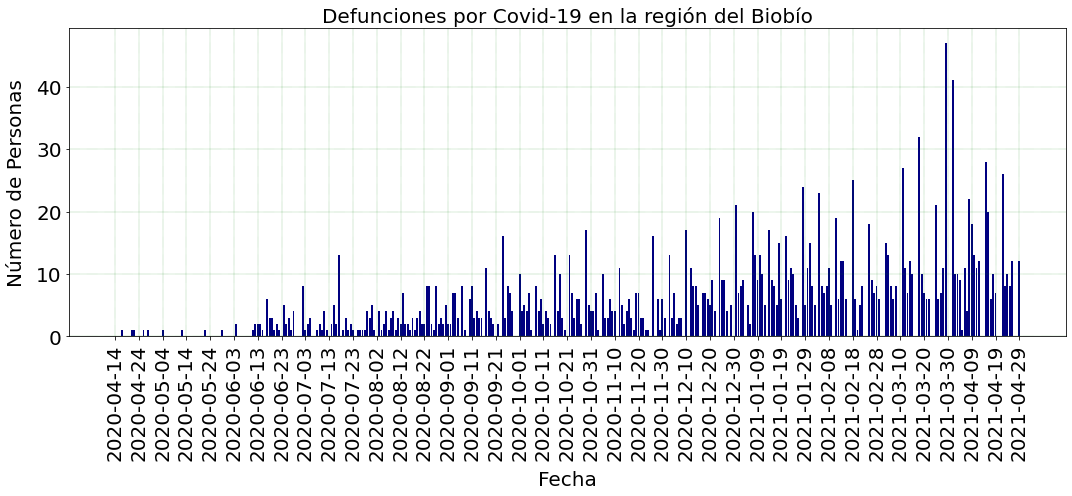

In [18]:
# Grafico imagen
plt.figure(figsize=(15,7))
plt.bar(fallecidos.fechas.values,fallecidos.fallecidos.values, color = 'navy')
plt.xticks(fallecidos.fechas.values[::10],rotation=90, fontsize = 20)
plt.yticks( fontsize = 20)
plt.grid(color='green', ls = ':', lw = 0.4)
plt.xlabel('Fecha', labelpad = 10, fontsize = 20)
plt.ylabel('Número de Personas',labelpad = 10,fontsize = 20)
plt.title('Defunciones por Covid-19 en la región del Biobío', fontsize = 20)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\fallecidos_biobio.pdf')

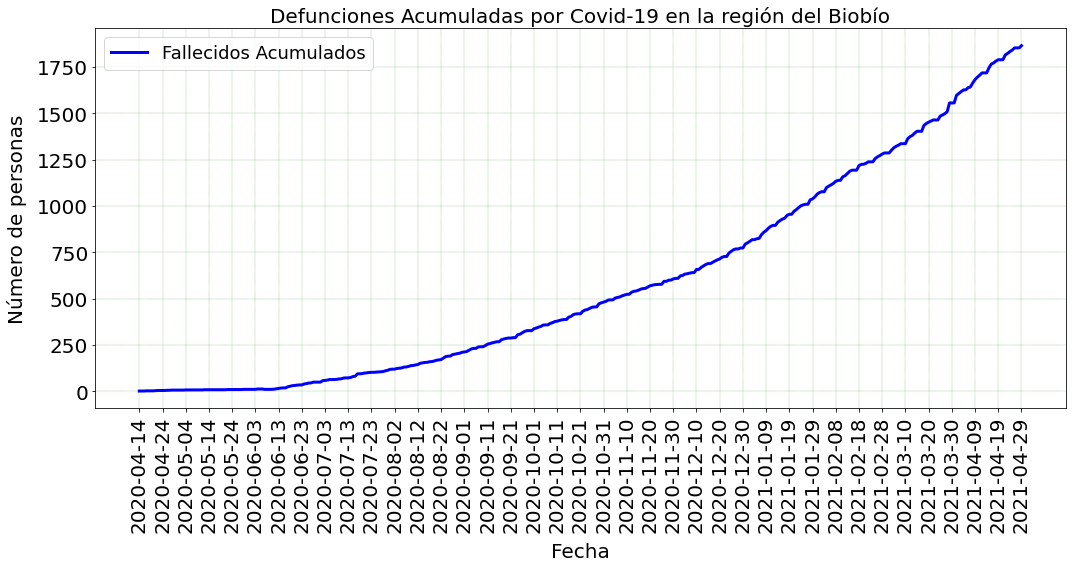

In [19]:
# Grafico imagen
plt.figure(figsize=(15,8))
plt.plot(df_fallecidos.fecha, df_fallecidos['total acumulados'].values, linewidth = 3, color = 'blue', label = 'Fallecidos Acumulados')
plt.xticks(fallecidos.fechas.values[::10],rotation=90,fontsize = 20 )
plt.yticks(fontsize = 20)
plt.grid(color='green', ls = ':', lw = 0.4)
plt.xlabel('Fecha', labelpad = 10, fontsize = 20)
plt.ylabel('Número de personas',labelpad = 10,fontsize = 20)
plt.title('Defunciones Acumuladas por Covid-19 en la región del Biobío', fontsize = 20)
plt.legend(fontsize = 18)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\fallecidos_acumulados_biobio.pdf')

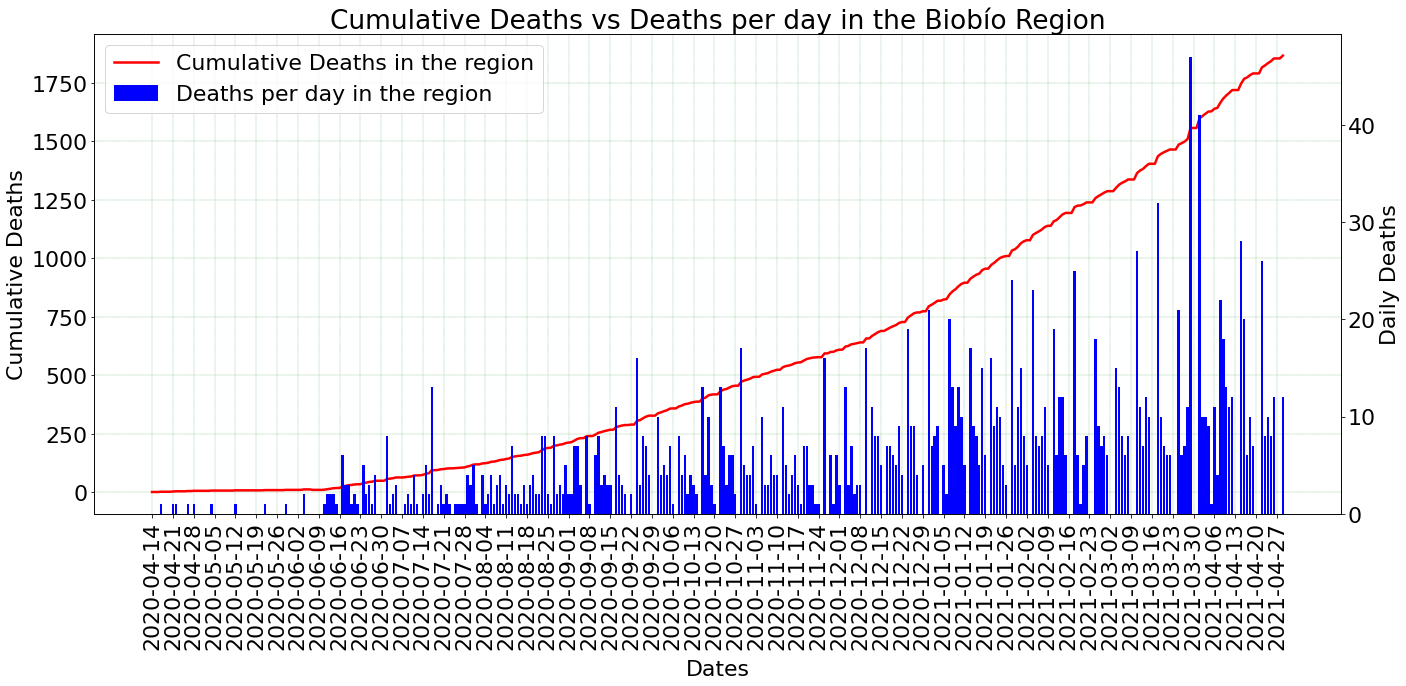

In [20]:
import matplotlib
matplotlib.rcParams["font.size"]=22
# Grafico
fig, ax1 = plt.subplots(figsize=(20,10))

# Lado izquierdo
ax1.set_xlabel('Dates', labelpad = 10)
ax1.set_ylabel('Cumulative Deaths')
ax1.plot(df_fallecidos.fecha.values, df_fallecidos['total acumulados'].values, linewidth = 2.5, color = 'red', 
         label = 'Cumulative Deaths in the region')
ax1.tick_params(axis='y')
ax1.axes.set_xticks(np.arange(len(fallecidos.fechas.values))[::7])
ax1.set_xticklabels(fallecidos.fechas.values[::7],rotation=90)


ax1.legend(fontsize = 20)

#Lado Derecho
ax2 = ax1.twinx()  
ax2.axes.set_xticks(np.arange(len(fallecidos.fechas.values))[::7])
ax2.set_xticklabels(fallecidos.fechas.values[::7],rotation=90,)
ax2.set_ylabel('Daily Deaths')
ax2.bar(fallecidos.fechas.values,fallecidos.fallecidos.values, color = 'blue', 
        label = 'Deaths per day in the region')
ax2.tick_params(axis='y')
# plt.xticks(np.arange(len(cuarentena.fechas.values[::10])),cuarentena.fechas.values[::10],rotation=90)
ax1.grid(color='green', ls = ':', lw = 0.4)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.xticks(cuarentena.fechas.values[::10],rotation=45)
# plt.grid(color='green', ls = ':', lw = 0.4)
plt.title('Cumulative Deaths vs Deaths per day in the Biobío Region')
# ax2.legend(loc=1)

# # added these three lines

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()

p = ax1.legend(h1+h2, l1+l2, loc=0)

# plt.show()
plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\paper\fallecidos_versus_biobio_ingles.pdf')


### E. Cuarentena 

In [21]:
# Datos de cuarentenas, cargado desde wikipedia
wiki = r'E:\Udec\Magister\Tesis\Modelo\Modelo Kathyanistico\cuarentena_biobio.csv'  # Carga del archivo
cuarentena = pd.read_csv(wiki).drop(['Unnamed: 0'], axis = 1).rename(columns={"por_cuarenta": "Porcentaje Comunas en Cuarentena"})
cuarentena = cuarentena[:].reset_index(drop=True)
# Visualizacion de DataFrame
print('Porcentaje Cuarentena Biobío\n',cuarentena)

Porcentaje Cuarentena Biobío
      Porcentaje Comunas en Cuarentena      fechas
0                            0.000000  2020-04-24
1                            0.000000  2020-04-25
2                            0.000000  2020-04-26
3                            0.000000  2020-04-27
4                            0.000000  2020-04-28
..                                ...         ...
358                         87.096774  2021-04-17
359                         87.096774  2021-04-18
360                         87.096774  2021-04-19
361                         87.096774  2021-04-20
362                         87.096774  2021-04-21

[363 rows x 2 columns]


In [22]:
archivo = r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\cuarentena1_biobio.csv'
cuarentenas = pd.read_csv(archivo)
# Thab total de habitantes, Phab % habitantes
cuarentenas = cuarentenas.rename(columns={'Unnamed: 0': "fechas"})
cuarentenas = cuarentenas[['fechas','Phab']]
# cuarentenas = cuarentenas[:345]
cuarentenas

,fechas,Phab
0,2020-04-25,0.000000
1,2020-04-26,0.000000
2,2020-04-27,0.000000
3,2020-04-28,0.000000
4,2020-04-29,0.000000
...,...,...
357,2021-04-17,94.338584
358,2021-04-18,94.338584
359,2021-04-19,94.338584
360,2021-04-20,94.338584


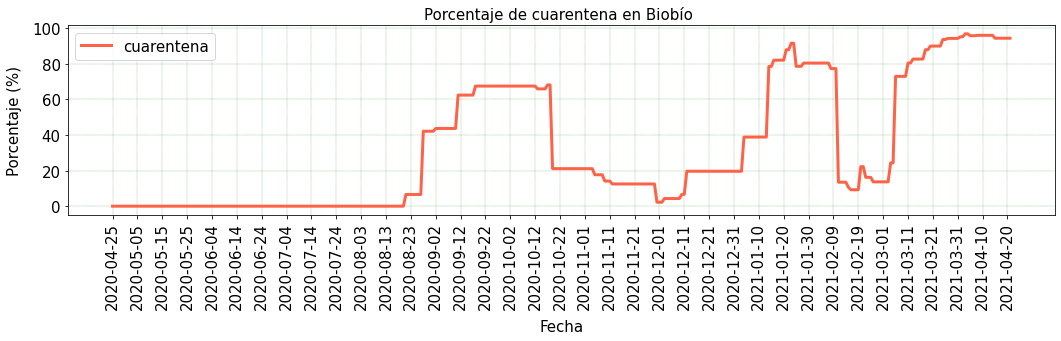

In [23]:
# Grafico imagen
matplotlib.rcParams["font.size"]=15
plt.figure(figsize=(15,5))
plt.plot(cuarentenas['fechas'].values, cuarentenas['Phab'].values, linewidth = 3, color = 'tomato', label = 'cuarentena')
plt.xticks(cuarentenas.fechas.values[::10],rotation=90)
plt.grid(color='green', ls = ':', lw = 0.4)
plt.xlabel('Fecha', labelpad = 10, fontsize = 15)
plt.ylabel('Porcentaje (%)',labelpad = 10,fontsize = 15)
plt.legend()
plt.title('Porcentaje de cuarentena en Biobío ', fontsize = 15)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\cuarentena_biobio.pdf')

In [24]:
# fallecidos = fallecidos[:370]
# cuarentenas

### F. Resumen Figuras

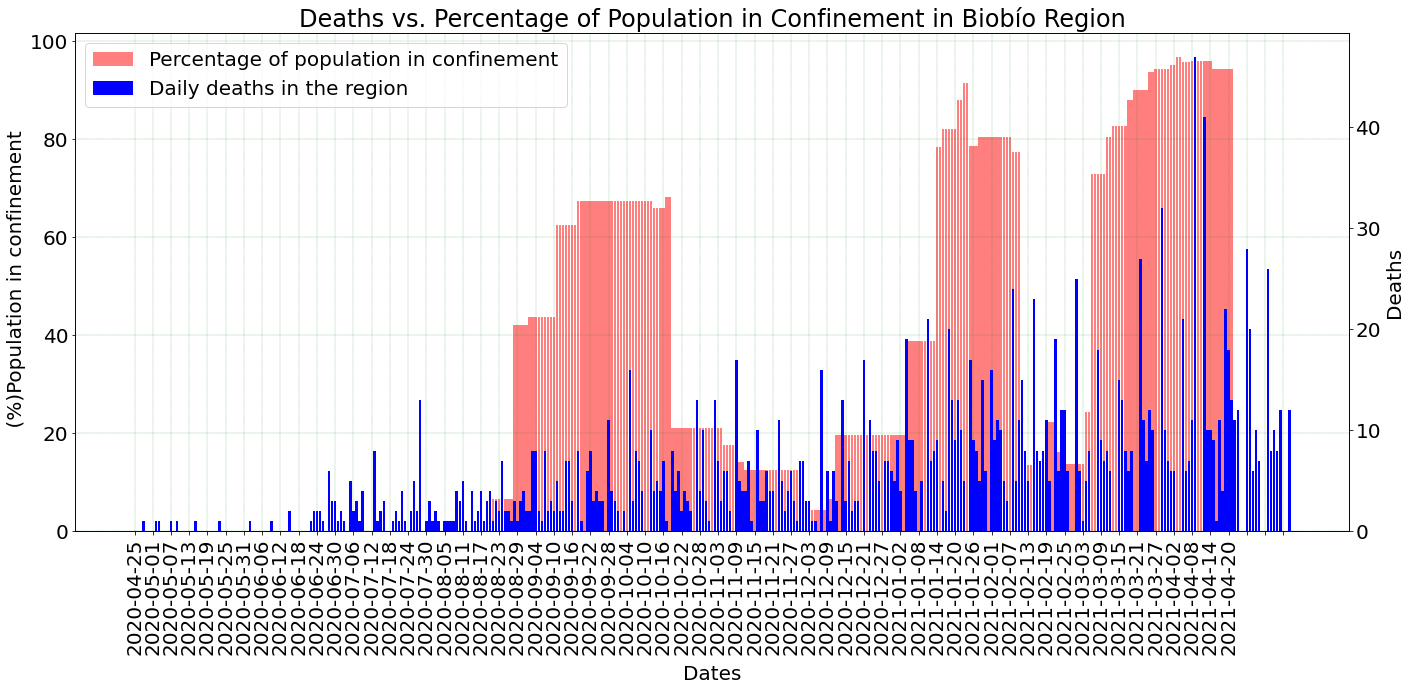

In [25]:
import matplotlib
matplotlib.rcParams["font.size"]=20
# Grafico
fig, ax1 = plt.subplots(figsize=(20,10))

# Lado izquierdo
ax1.set_xlabel('Dates', labelpad = 10)
ax1.set_ylabel(' (%)Population in confinement')
ax1.bar(cuarentenas['fechas'].values, cuarentenas['Phab'].values, linewidth = 2, color = 'red', alpha=0.5, 
         label = 'Percentage of population in confinement')
ax1.tick_params(axis='y')
ax1.axes.set_xticks(np.arange(len(cuarentenas.fechas.values))[::6])
ax1.set_xticklabels(cuarentenas.fechas.values[::6],rotation=90)
# ax1.legend()

#Lado Derecho
ax2 = ax1.twinx()  
ax2.axes.set_xticks(np.arange(len(cuarentenas.fechas.values))[::6])
ax2.set_xticklabels(cuarentenas.fechas.values[::6],rotation=90)
ax2.set_ylabel('Deaths')
ax2.bar(fallecidos.fechas.values,fallecidos.fallecidos.values, color = 'blue' ,
        label = 'Daily deaths in the region')
ax2.tick_params(axis='y')
# plt.xticks(np.arange(len(cuarentena.fechas.values[::6])),cuarentena.fechas.values[::6],rotation=90)
ax1.grid(color='green', ls = ':', lw = 0.4)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(fallecidos.fechas.values[::6],rotation=45)
# plt.grid(color='green', ls = ':', lw = 0.4)
plt.title('Deaths vs. Percentage of Population in Confinement in Biobío Region')
# ax2.legend(loc=2)


h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()

p = ax1.legend(h1+h2, l1+l2, loc=0)

plt.tight_layout()

plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\paper\cuarentena_vs_fallecido_biobio_ingles.pdf')

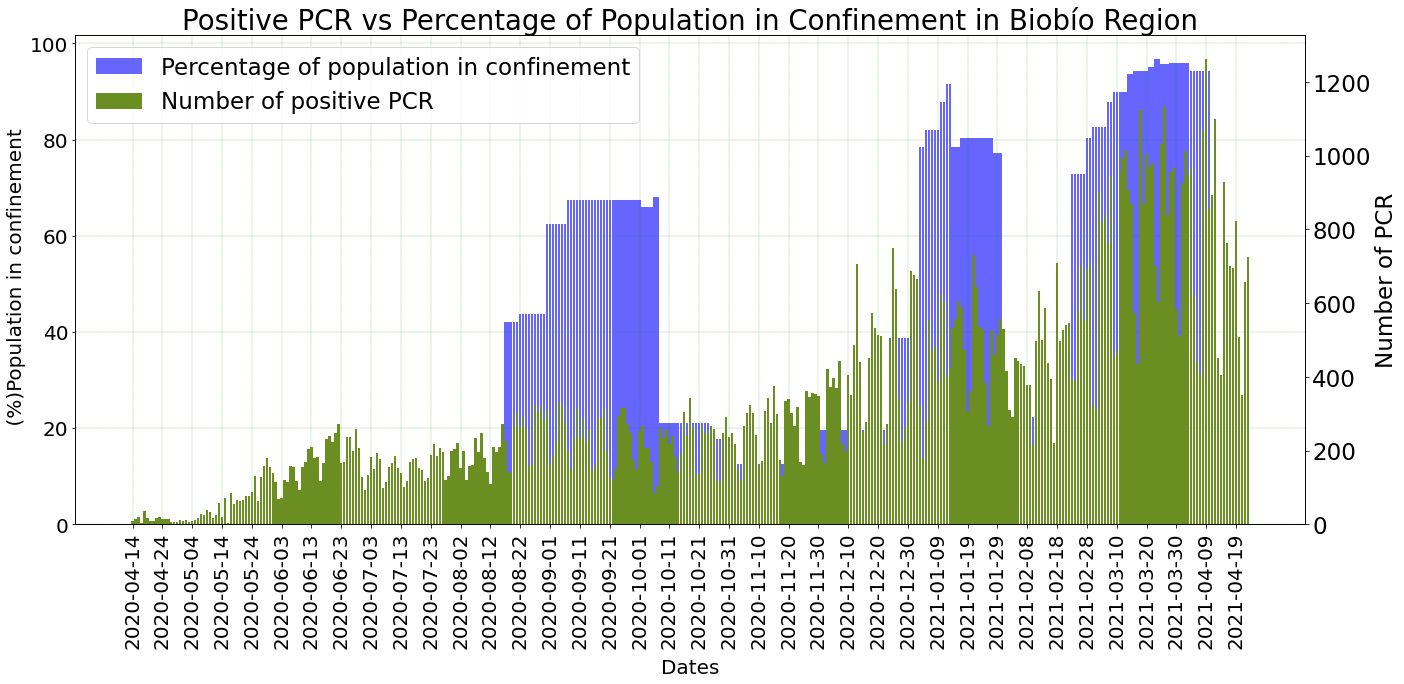

In [26]:
fig, ax1 = plt.subplots(figsize=(20,10))
matplotlib.rcParams["font.size"]=23
# Lado izquierdo
ax1.set_xlabel('Dates', labelpad = 10)
ax1.set_ylabel(' (%)Population in confinement')
# ax1.axvline(vacaciones_in.iloc[0], label = 'Inicio permiso vacaciones',linewidth=3, color = 'blue')
# ax1.plot(cuarentena['fechas'].values, cuarentena['Porcentaje Cuarentena'].values, linewidth = 3, color = 'red', 
#          label = 'Porcentaje de Cantidad de Comunas en Cuarentena')
plt.bar(cuarentenas['fechas'].values,cuarentenas['Phab'].values, alpha = 0.6, color = 'blue', label = 'Percentage of population in confinement')
ax1.tick_params(axis='y')
ax1.axes.set_xticks(np.arange(len(cuarentenas.fechas.values))[::10])
ax1.set_xticklabels(cuarentenas.fechas.values[::10],rotation=90)
# ax1.legend()

#Lado Derecho
ax2 = ax1.twinx()  

# ax2.axes.set_xticks(np.arange(len(cuad_pcr.fechas.values))[::espaciado])
# ax2.set_xticklabels(cuad_pcr.fechas.values[::espaciado],rotation=90)
ax2.axes.set_xticks(np.arange(len(pcr_positivo['fecha'].values))[::10])
ax2.set_xticklabels(pcr_positivo['fecha'].values[::10],rotation=90)
ax2.set_ylabel('Number of PCR')
ax2.bar(pcr_positivo['fecha'], pcr_positivo['positivos'], label = 'Number of positive PCR', color = 'olivedrab')
ax2.tick_params(axis='y')
ax1.grid(color='green', ls = ':', lw = 0.4)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Positive PCR vs Percentage of Population in Confinement in Biobío Region')
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()

p = ax1.legend(h1+h2, l1+l2, loc=0)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\paper\cuarentena_vs_pcr_biobio_ingles.pdf')

In [27]:
vacaciones_in  = camas_covid[camas_covid.fecha == '2021-01-04'].fecha
vacaciones_fin = camas_covid[camas_covid.fecha == '2021-03-31'].fecha

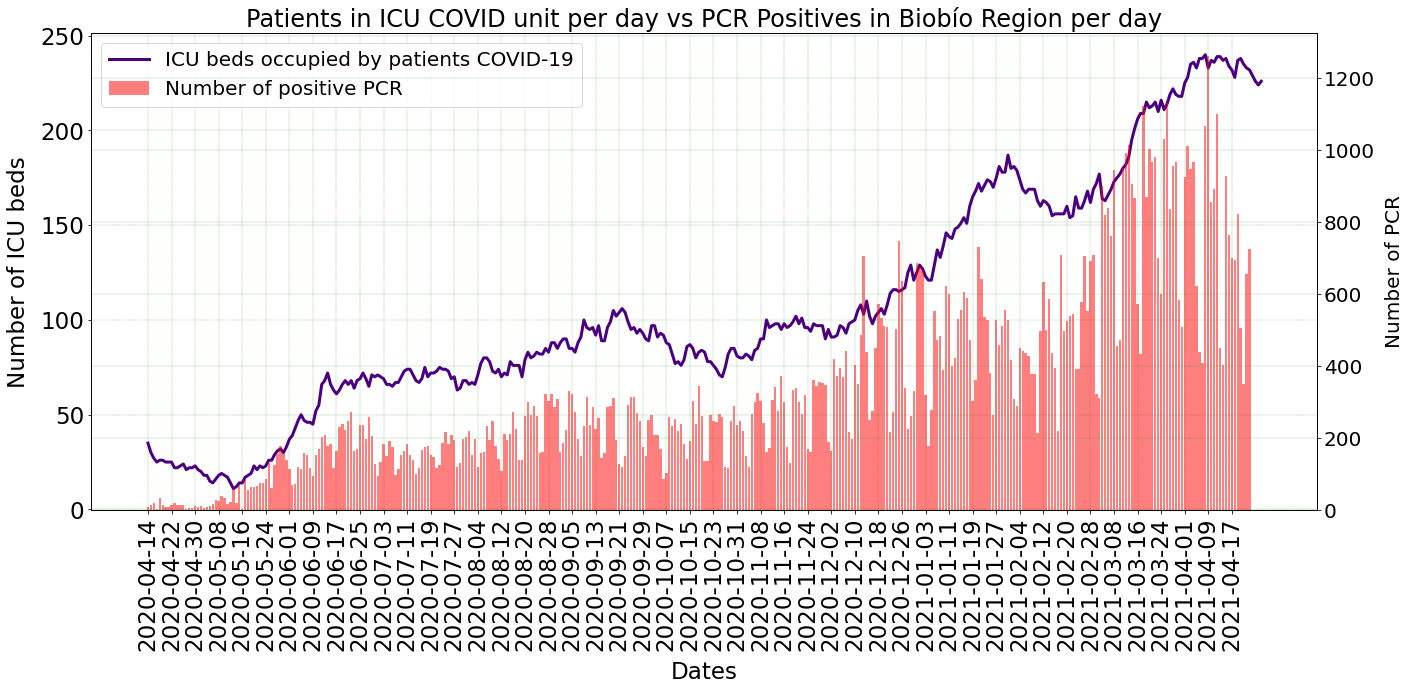

In [28]:
# Grafico
fig, ax1 = plt.subplots(figsize=(20,10))
matplotlib.rcParams["font.size"]=20

# Lado izquierdo
ax1.plot(camas_covid['fecha'].values,camas_covid['camas ocupadas covid'].values,linewidth=3, color = 'indigo', label = 'ICU beds occupied by patients COVID-19')
# ax1.axvline(vacaciones_in.iloc[0], label = 'Inicio permiso vacaciones',linewidth=3, color = 'blue')
# ax1.axvline(vacaciones_fin.iloc[0], label = 'Fin permiso vacaciones',linewidth=3, color = 'black')
ax1.axes.set_xticks(np.arange(len(camas_covid['fecha'].values))[::10])
ax1.set_xticklabels(camas_covid['fecha'].values[::10],rotation=90)
# ax1.grid(color='green', ls = ':', lw = 0.4)
ax1.set_xlabel('Dates', labelpad = 10)
ax1.set_ylabel('Number of ICU beds',labelpad = 10)
ax1.legend(loc=2)
# ax1.title.set_text("Pacientes en unidad UCI COVID por día en la región del Biobio")


#Lado Derecho
ax2 = ax1.twinx()  
# ax2.bar(pcr_positivo['fecha'], pcr_positivo['pcr'], label = 'Cantidad PCR realizados', alpha = 0.5)
ax2.bar(pcr_positivo['fecha'].values, pcr_positivo['positivos'].values, label = 'Number of positive PCR', color = 'red', alpha = 0.5)
ax2.axes.set_xticks(np.arange(len(pcr_positivo['fecha'].values))[::8])
ax2.set_xticklabels(pcr_positivo['fecha'].values[::8],rotation=90)
ax1.grid(color='green', ls = ':', lw = 0.4)
ax2.set_xlabel('Dates',  labelpad = 10)
ax2.set_ylabel('Number of PCR',labelpad = 10)
ax2.grid(color='green', ls = ':', lw = 0.4)

plt.title('Patients in ICU COVID unit per day vs PCR Positives in Biobío Region per day')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()

p = ax1.legend(h1+h2, l1+l2, loc=0)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\paper\uci_vs_pcr_vacaciones_biobio_ingles.pdf')


## II. Modelos

In [29]:
# Iniciamos semilla, para generar los mismos datos aleatorios para cada ejecucion
seed= 42

### A. Visualizacion de datos

In [30]:
# Carga de datos y ajuste de nombre de columnas
pcr_positivo       = pcr_positivo.rename({"fecha": "fechas"},axis=1) 
# df_uci             = df_uci.rename({"dates": "fechas", "hospitalizations":"hospitalizaciones"},axis=1)
camas_disponibles  = camas_disponibles.rename({"fecha": "fechas"},axis=1)
camas_usadas       = camas_covid.rename({"fecha": "fechas"},axis=1)


# Union de datos para juntar todo en un DataFrame
datos = pd.merge(camas_disponibles,camas_usadas)
datos = pd.merge(pd.merge(pcr_positivo,datos),fallecidos)
datos = pd.merge(datos,cuarentenas)

datos.columns

Index(['fechas', 'pcr', 'positividad', 'positivos', 'total disponibles',
       'camas ocupadas covid', 'fallecidos', 'Phab'],
      dtype='object')

In [31]:
# Objetos a enteros para obtener metricas
# datos['hospitalizaciones']    = datos['hospitalizaciones'].astype(int)
datos['total disponibles']    = datos['total disponibles'].astype(int)
datos['camas ocupadas covid'] = datos['camas ocupadas covid'].astype(int)
datos = datos.drop(['positividad'], axis=1)

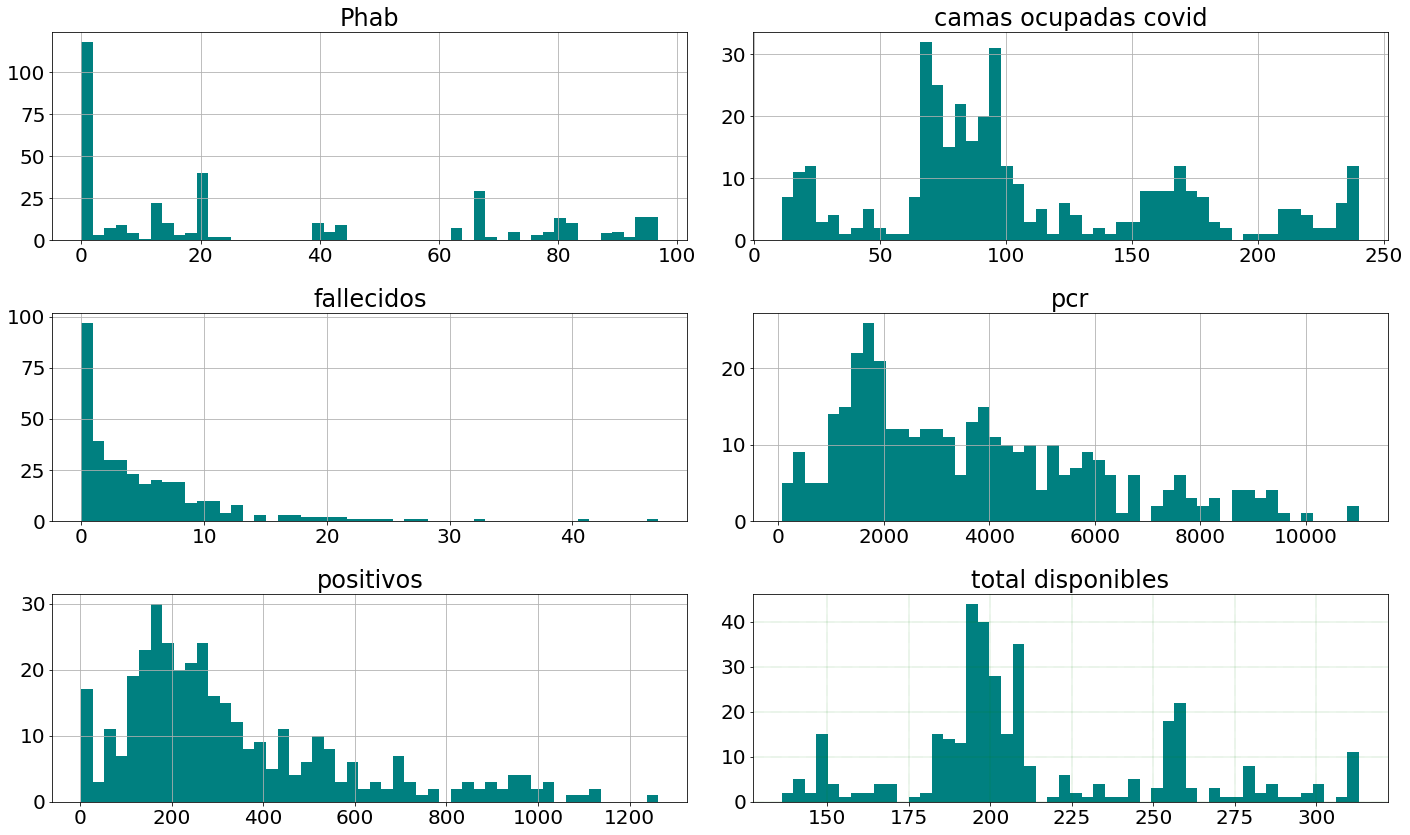

In [32]:
# Histograma
datos.hist(bins=50, figsize=(20,12), color = 'teal' )
matplotlib.rcParams["font.size"]= 20
plt.grid(color='green', ls = ':', lw = 0.4)
# plt.suptitle('Histogramas Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\histogramas_biobio.pdf')

In [33]:
datos

,fechas,pcr,positivos,total disponibles,camas ocupadas covid,fallecidos,Phab
0,2020-04-25,354,14,150,23,0.0,0.000000
1,2020-04-26,404,15,150,24,1.0,0.000000
2,2020-04-27,174,5,152,21,0.0,0.000000
3,2020-04-28,234,6,149,22,1.0,0.000000
4,2020-04-29,230,6,150,22,0.0,0.000000
...,...,...,...,...,...,...,...
357,2021-04-17,7250,702,310,232,6.0,94.338584
358,2021-04-18,7200,695,312,228,10.0,94.338584
359,2021-04-19,8670,824,312,237,7.0,94.338584
360,2021-04-20,5579,507,313,238,0.0,94.338584


In [34]:
# Matriz de datos
datos1 = datos.rename({"pcr": "PCR realizados [x1]","positivos": "Positivos [x2]","total disponibles": "Total camas [x3]",
                      'camas ocupadas covid': "Camas UCI COVID-19 [y]" , "fallecidos" : "Fallecidos [x4]",
                       "Phab": "Porcentaje Población en Confinamiento [x5]" },axis=1)
datos1 = datos1[["fechas","PCR realizados [x1]", "Positivos [x2]","Total camas [x3]" ,"Fallecidos [x4]", 
                  "Porcentaje Población en Confinamiento [x5]","Camas UCI COVID-19 [y]"]]

# Visualizacion de DataFrame
print('Matriz de Datos para Región del Biobío\n')
datos1
# np.save("datos_conce.npy", datos1)

Matriz de Datos para Región del Biobío



,fechas,PCR realizados [x1],Positivos [x2],Total camas [x3],Fallecidos [x4],Porcentaje Población en Confinamiento [x5],Camas UCI COVID-19 [y]
0,2020-04-25,354,14,150,0.0,0.000000,23
1,2020-04-26,404,15,150,1.0,0.000000,24
2,2020-04-27,174,5,152,0.0,0.000000,21
3,2020-04-28,234,6,149,1.0,0.000000,22
4,2020-04-29,230,6,150,0.0,0.000000,22
...,...,...,...,...,...,...,...
357,2021-04-17,7250,702,310,6.0,94.338584,232
358,2021-04-18,7200,695,312,10.0,94.338584,228
359,2021-04-19,8670,824,312,7.0,94.338584,237
360,2021-04-20,5579,507,313,0.0,94.338584,238


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000198CCFE1EC8>,
      dtype=object)

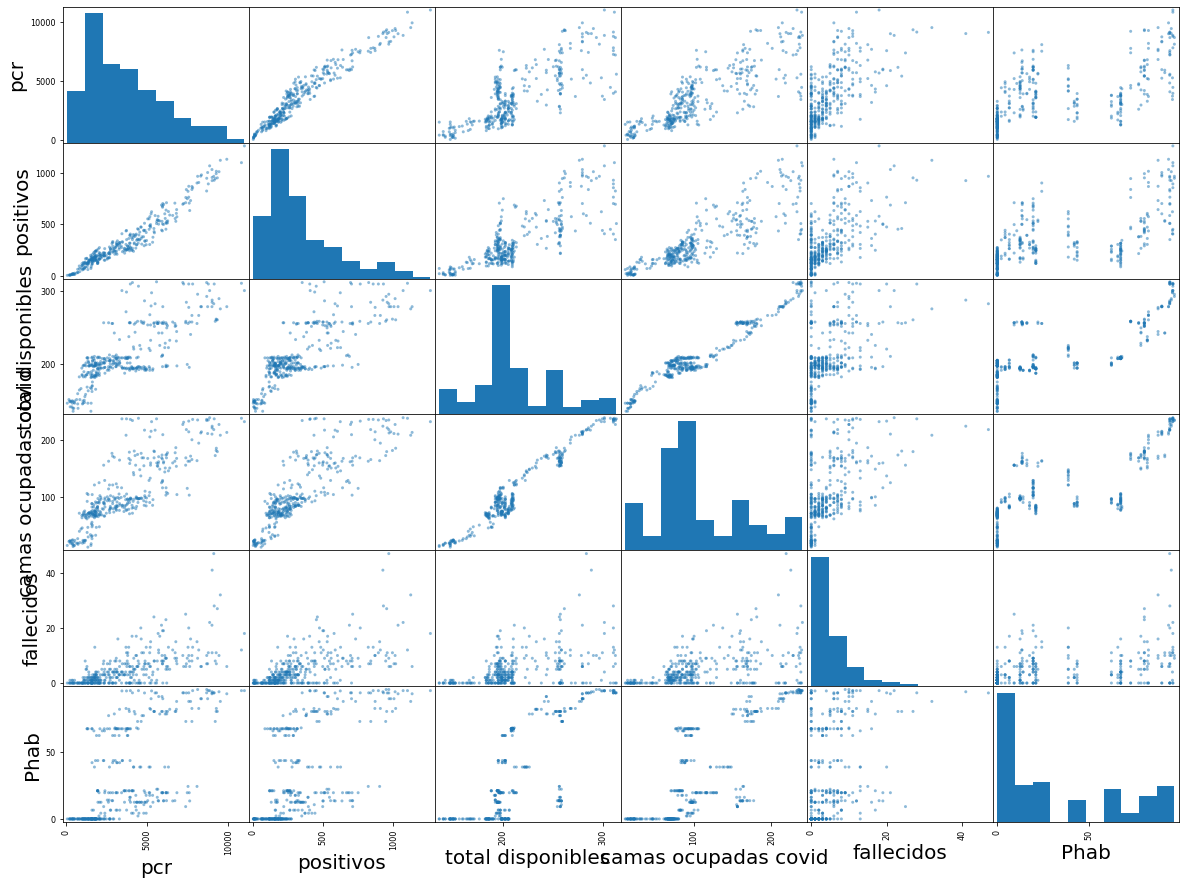

In [35]:
#Scatter Datos
atributos = ['pcr', 'positivos','total disponibles','camas ocupadas covid','fallecidos', 'Phab']
scatter_matrix(datos[atributos], figsize=(20, 15))
# save_fig("scatter_matrix_plot")

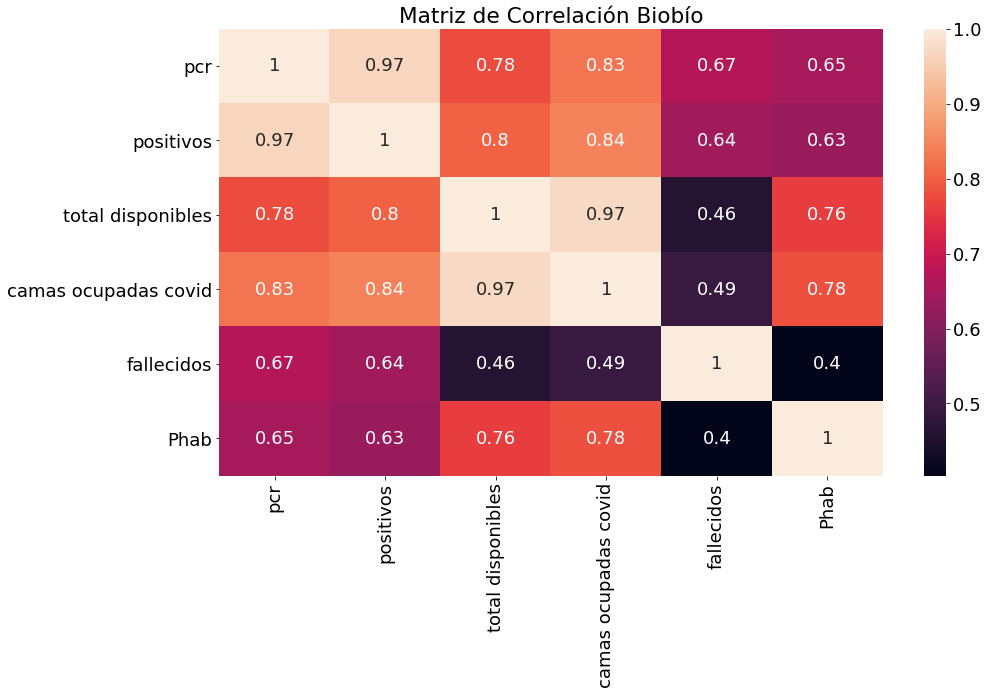

In [36]:
# Matriz Correlacion
import seaborn as sns 
matplotlib.rcParams["font.size"]= 18
correlacion = datos[atributos].corr()
plt.figure(figsize=(15,10))
plt.title('Matriz de Correlación Biobío')
sns.heatmap(correlacion, annot =True)

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\correlacion_biobio.pdf')

In [37]:
# Descripcion de datos
datos.describe()

,pcr,positivos,total disponibles,camas ocupadas covid,fallecidos,Phab
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,3642.610497,337.342541,212.546961,107.621547,4.939227,32.044494
std,2358.910836,254.560365,39.564027,58.384558,6.261314,34.607024
min,70.000000,3.000000,136.000000,11.000000,0.000000,0.000000
25%,1754.250000,161.250000,194.000000,71.000000,0.000000,0.000000
50%,3133.000000,261.500000,202.000000,92.000000,3.000000,18.635965
75%,5119.750000,449.000000,240.250000,155.750000,7.000000,67.457542
max,11000.000000,1263.000000,313.000000,240.000000,47.000000,96.815841


### B. Proyección

In [38]:
# Se realiza la proyección 
datos_grandes = datos.drop(["fechas"],axis=1).apply(dias_extras)  # Agrego días extras
fechas = datos.fechas.values                                      # Copio las fechas

fecha_base = datetime.strptime(fechas[-1], "%Y-%m-%d")            # Se le da formato a las fechas
                                                                  # Se generan las fechas
fechas_generadas = [(fecha_base + timedelta(days = int(dia))).strftime("%Y-%m-%d")  for dia in np.arange(1,20+1)]
fechas = np.concatenate([fechas,fechas_generadas])                # Concatenación de los datos en un archivo

# Se copia todo en un archivo
datos_grandes["fechas"] = fechas
datos = datos_grandes.copy()

### C. Modelos

In [39]:
#Separamos caracteristicas de variables que se predeciran. 
# Se separo en x e y, "y" corresponde a la cantidad de hospitalizaciones predichas
y = datos['camas ocupadas covid'].values
X = datos.drop(['camas ocupadas covid',"fechas"],axis=1).values

In [83]:
X = Normalizer().fit_transform(X)

In [40]:
# se dividen los datos en conjunto de entrenamiento y de test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33, random_state=seed)

In [85]:
# # Visualización de los Datos
# print('Datos para Región de Biobío\n')
# print('1. X Entrenamiento:\n', x_train1)
# print('\n2. X Test:\n', x_test1)
# print('\n3. Y Entrenamiento:\n', y_train1)
# print('\n4. Y Test:\n', y_test1)

In [86]:
#X_train.shape,y_train.shape

#### A. Árbol de regresion

In [87]:
# Calculo de Arbol de Regresión
tree_reg = RandomForestRegressor(n_estimators = 10, random_state=42).fit(x_train1, y_train1)

# Obtiene la prediccion
y_pred1 = tree_reg .predict(x_test1)

In [88]:
# Visualización de Metricas resultantes
print('Resultado Metricas del Árbol de Regresión Región del Biobío')
print("- r2_score", r2_score(y_test1,y_pred1))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test1,y_pred1)) 
print("- mean_squared_error", mean_squared_error(y_test1,y_pred1))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test1,y_pred1))

print('\nResultado Metricas del Árbol de Regresión Región del Biobío')
print("{:.4f}".format(r2_score(y_test1,y_pred1)) )   #bondad del ajuste
print("{:.4f}".format(mean_absolute_error(y_test1,y_pred1))) 
print("{:.4f}".format(mean_squared_error(y_test1,y_pred1)))
print("{:.4f}".format(mean_absolute_percentage_error(y_test1,y_pred1)))

Resultado Metricas del Árbol de Regresión Región del Biobío
- r2_score 0.8309026573694798
- mean_absolute_error 16.9496062992126
- mean_squared_error 728.8195275590552
- mean_absolute_percentage_error 0.18700382304577218

Resultado Metricas del Árbol de Regresión Región del Biobío
0.8309
16.9496
728.8195
0.1870


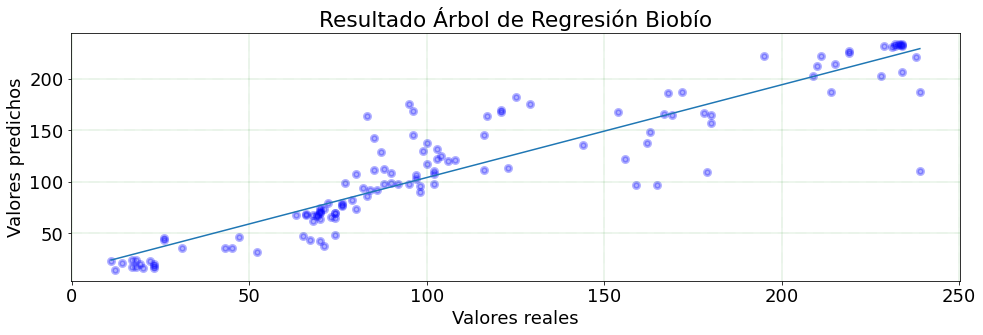

In [89]:
# Grafico Ajuste
plt.figure(figsize=(14,5))
plt.scatter(y_test1,y_pred1, alpha = 0.3,  color = 'blue', linewidth = 3)
plt.plot(np.unique(y_test1), np.poly1d(np.polyfit(y_test1, y_pred1, 1))(np.unique(y_test1)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='green', ls = ':', lw = 0.4)
plt.title('Resultado Árbol de Regresión Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\arbol_regresion_biobio.pdf')

#### B. Regresión Lineal

In [90]:
# Realiza la regresion lineal
reg = LinearRegression(n_jobs=-1).fit(x_train1, y_train1) # n_jobs=-1 utiliza todos los nucleos

# Obtiene la prediccion
y_pred1 = reg.predict(x_test1)

In [91]:
# Visualización de Metricas resultantes
print('Resultado Metricas de Regresion Lineal Región del Biobío')
print("- r2_score", r2_score(y_test1,y_pred1))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test1,y_pred1)) 
print("- mean_squared_error", mean_squared_error(y_test1,y_pred1))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test1,y_pred1))

print("{:.4f}".format(r2_score(y_test1,y_pred1)) )   #bondad del ajuste
print("{:.4f}".format(mean_absolute_error(y_test1,y_pred1))) 
print("{:.4f}".format(mean_squared_error(y_test1,y_pred1)))
print("{:.4f}".format(mean_absolute_percentage_error(y_test1,y_pred1)))

Resultado Metricas de Regresion Lineal Región del Biobío
- r2_score 0.5568587241289489
- mean_absolute_error 36.75760331481483
- mean_squared_error 1909.9650550272102
- mean_absolute_percentage_error 0.6046631560544299
0.5569
36.7576
1909.9651
0.6047


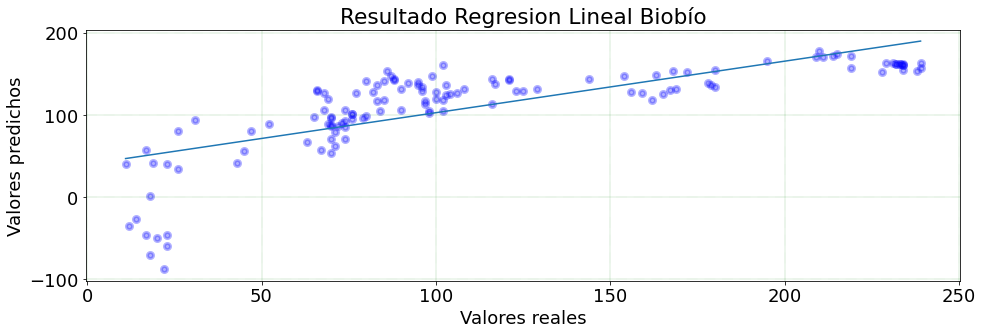

In [92]:
# Grafico Ajuste
plt.figure(figsize=(14,5))
plt.scatter(y_test1,y_pred1, alpha = 0.3, color = 'blue', linewidth = 3)
plt.plot(np.unique(y_test1), np.poly1d(np.polyfit(y_test1, y_pred1, 1))(np.unique(y_test1)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='green', ls = ':', lw = 0.4)
plt.title('Resultado Regresion Lineal Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\regresion_lineal_biobio.pdf')

#### C. Elastic Net

In [121]:
# Calculo Elastic Net
regr = ElasticNet(random_state=seed,max_iter = 10000, alpha= 100).fit(x_train1, y_train1)

# Obtiene la prediccion
y_pred1 = regr.predict(x_test1)
# x_pred1 = regr.predict(y_test1)

In [122]:
# Visualización de Metricas resultantes
print('Resultado Elastic Net Región del Biobío')
print("- r2_score", r2_score(y_test1,y_pred1))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test1,y_pred1)) 
print("- mean_squared_error", mean_squared_error(y_test1,y_pred1))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test1,y_pred1))

print("{:.4f}".format(r2_score(y_test1,y_pred1)) )   #bondad del ajuste
print("{:.4f}".format(mean_absolute_error(y_test1,y_pred1))) 
print("{:.4f}".format(mean_squared_error(y_test1,y_pred1)))
print("{:.4f}".format(mean_absolute_percentage_error(y_test1,y_pred1)))

Resultado Elastic Net Región del Biobío
- r2_score 0.9651567537954785
- mean_absolute_error 9.558090153484368
- mean_squared_error 150.17644773336485
- mean_absolute_percentage_error 0.13171750095457427
0.9652
9.5581
150.1764
0.1317


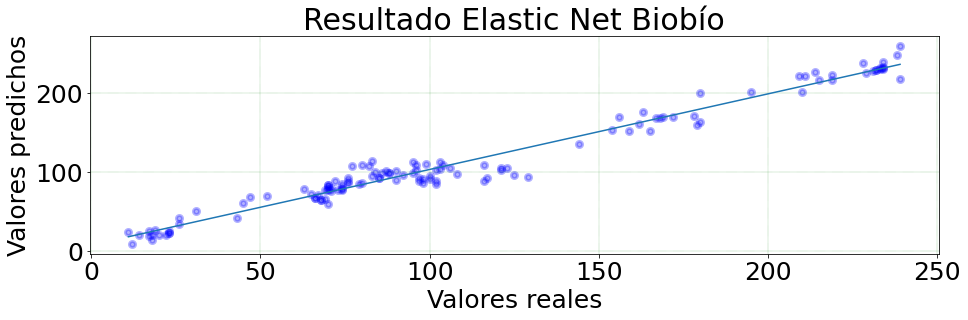

In [123]:
# Grafico Ajuste
plt.figure(figsize=(14,5))
plt.scatter(y_test1,y_pred1, alpha = 0.3, color = 'blue', linewidth = 3)
plt.plot(np.unique(y_test1), np.poly1d(np.polyfit(y_test1, y_pred1, 1))(np.unique(y_test1)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Resultado Elastic Net Biobío')
plt.tight_layout()
plt.grid(color='green', ls = ':', lw = 0.4)

plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\elastic_net_biobio.pdf')

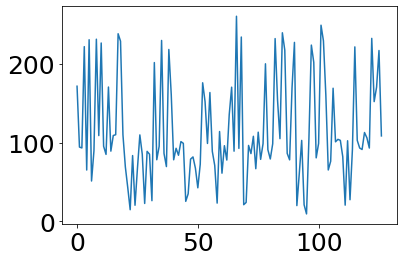

In [124]:
plt.plot(y_pred1)

#### D. Red Neuronal

In [96]:
# Calculo red

mlp = MLPRegressor(hidden_layer_sizes=3,random_state=seed, max_iter=100000,activation="logistic").fit(x_train1, y_train1)

# Obtiene la prediccion
y_pred1 = mlp.predict(x_test1)
y_pred2 = mlp.predict(x_train1)

In [97]:
import joblib

In [98]:
# joblib.dump(mlp,"red_mlp_sklearn")

In [99]:
# Visualización de Metricas resultantes
print('Resultado Red Neuronal Región del Biobío')
print("- r2_score", r2_score(y_test1,y_pred1))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test1,y_pred1)) 
print("- mean_squared_error", mean_squared_error(y_test1,y_pred1))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test1,y_pred1))

print('\nResultado Metricas del Árbol de Regresión Región del Biobío')
print("{:.4f}".format(r2_score(y_test1,y_pred1)) )   #bondad del ajuste
print("{:.4f}".format(mean_absolute_error(y_test1,y_pred1))) 
print("{:.4f}".format(mean_squared_error(y_test1,y_pred1)))
print("{:.4f}".format(mean_absolute_percentage_error(y_test1,y_pred1)))

Resultado Red Neuronal Región del Biobío
- r2_score 0.7629676067708273
- mean_absolute_error 26.819679505202426
- mean_squared_error 1021.6236054456936
- mean_absolute_percentage_error 0.39987888494566864

Resultado Metricas del Árbol de Regresión Región del Biobío
0.7630
26.8197
1021.6236
0.3999


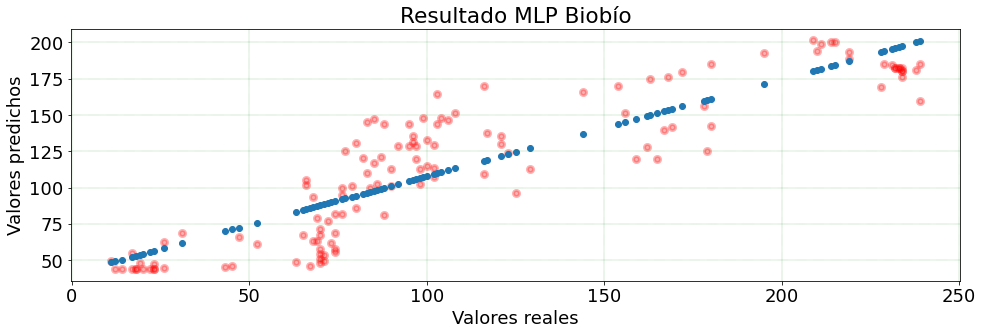

In [100]:
# Grafico Ajuste
plt.figure(figsize=(14,5))
plt.scatter(y_test1,y_pred1, alpha = 0.3, color = 'red', linewidth = 3)
plt.scatter(np.unique(y_test1), np.poly1d(np.polyfit(y_test1, y_pred1, 1))(np.unique(y_test1)))
# plt.scatter(x_train1, y_pred2, color = 'green')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='green', ls = ':', lw = 0.4)
plt.title('Resultado MLP Biobío')

plt.tight_layout()
plt.title('Resultado MLP Biobío')
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\mlp_biobio.pdf')

In [101]:
# Validación Cruzada
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, x_train1, y_train1,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [102]:
# Puntaje
scores

array([-1444.03653846,  -607.95346154,  -303.06076923,  -172.74730769,
        -692.71653846,  -556.0824    ,  -917.6796    ,  -414.7296    ,
        -547.2028    ,  -925.5788    ])

### Serie de tiempo

In [103]:
# Division de los datos
# X,y,fechas  =  datos.drop(['camas ocupadas covid',"fechas"],axis=1).values,datos['camas ocupadas covid'].values,datos.fechas.values

In [104]:
def create_segments_and_labels(X,y, time_steps, step):
    from scipy import stats
    # aceleración x, y, z como características
    N_FEATURES = X.shape[1]
    # Número de pasos para avanzar en cada iteración (para mí, siempre debe
    # ser igual al tiempo_pasos para no tener solapamiento entre segmentos)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(X) - time_steps, step):
        xs = X[i: i + time_steps,0]
        ys = X[i: i + time_steps,1]
        zs = X[i: i + time_steps,2]
        ws = X[i: i + time_steps,3]
        vs = X[i: i + time_steps,4]
#         us = X[i: i + time_steps,5]
#         wus = X[i: i + time_steps,6]
        # Recuperar la etiqueta más utilizada en este segmento
        label = stats.mode(y[i: i + time_steps])[0][0]
        segments.append([xs, ys, zs, ws,vs])
        labels.append(label)

    #Poner los segmentos en mejor forma
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

#### E. Perceptron (serie 1)

In [105]:
TIME_PERIODS = 1   # Periodo de Tiempos
STEP_DISTANCE =1   # Distancia
batch_size = 5    # Tamaño 
N_FEATURES =  X.shape[1]   # Cantidad de N

input_shape = (TIME_PERIODS*N_FEATURES)
# input_shape

# Dividir entre train y test
X = Normalizer().fit_transform(X)
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
Xtrain, Xtest = X[0:train_size,:], X[train_size:len(X),:]
ytrain, ytest = y[0:train_size], y[train_size:len(X)]
fechas_train,fechas_test =  fechas[0:train_size], fechas[train_size:len(X)]


# Divide segmentos
x_train1, y_train1 = create_segments_and_labels(Xtrain,
                                              ytrain,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

x_test1, y_test1 = create_segments_and_labels(Xtest,
                                              ytest,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

In [106]:
# fechas[train_size:len(X)],fechas[train_size]

 Necesario para el perceptron

In [110]:
# crear y ajustar el modelo Perceptrón Multicapa
model = Sequential()
# model.add(Reshape((TIME_PERIODS, N_FEATURES), input_shape=(input_shape,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))

# print(model.summary())

In [111]:
# # Entrenamiento con optimizador Adam
model.compile(loss='mean_squared_error', optimizer='adam')
# history = model.fit(x_train1, y_train1, epochs=80000, batch_size=batch_size, verbose=2  )
model.load_weights("modelo_mlp_biobio_27_04.pkl") # mejor modelo 27.04
model.compile(loss='mean_squared_error', optimizer='adam')


In [112]:
# Estimación del modelo
trainScore = model.evaluate(x_train1, y_train1, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(x_test1, y_test1, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 16.54 MSE (4.07 RMSE)
Test Score: 5153.75 MSE (71.79 RMSE)


In [113]:
## Grafica Optimizacion
plt.figure(figsize=(15,8))
plt.plot(history.epoch,history.history['loss'],color = 'blue', linewidth = 2)
plt.xlabel('épocas')
plt.ylabel('mse')
plt.grid(color='green', ls = ':', lw = 0.4)
plt.title('Optimización MLP del Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\mlp_keras_biobio.pdf')

NameError: name 'history' is not defined

<Figure size 1080x576 with 0 Axes>

In [114]:
# Genera predicciones para entrenamiento
trainPredict = np.squeeze(model.predict(x_train1))
testPredict  = np.squeeze(model.predict(x_test1))

In [115]:
print("- r2_score", r2_score(y_test1,testPredict))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test1,testPredict)) 
print("- mean_squared_error", mean_squared_error(y_test1,testPredict))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test1,testPredict))


print("{:.4f}".format(r2_score(y_test1,testPredict))  ) #bondad del ajuste
print("{:.4f}".format(mean_absolute_error(y_test1,testPredict)) )
print("{:.4f}".format( mean_squared_error(y_test1,testPredict)))
print("{:.4f}".format(mean_absolute_percentage_error(y_test1,testPredict)))

- r2_score -3.419791196991654
- mean_absolute_error 65.74158950079055
- mean_squared_error 5153.747135153309
- mean_absolute_percentage_error 0.3370174357595152
-3.4198
65.7416
5153.7471
0.3370


In [116]:
# Ajuste Formato Fechas
# fecha_hoy = datetime.now().strftime("%Y-%m-%d")
fecha_hoy = '2021-03-26'
idx_fecha_hoy = np.argwhere(fechas_test==fecha_hoy)[0][0] + len(trainPredict)
# idx_fecha_hoy = train_size

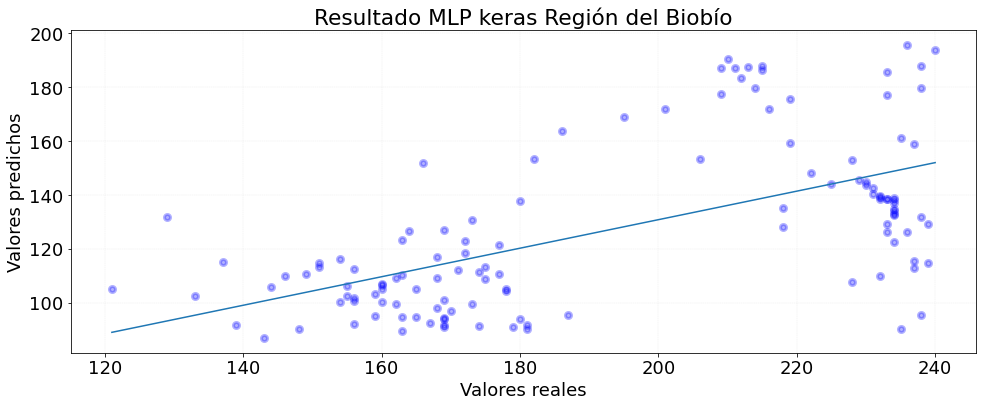

In [117]:
# Grafico Ajuste
plt.figure(figsize=(14,6))
plt.scatter(y_test1,testPredict, alpha = 0.3, color = 'blue', linewidth = 3)
plt.plot(np.unique(y_test1), np.poly1d(np.polyfit(y_test1, testPredict, 1))(np.unique(y_test1)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.title('Resultado MLP keras Región del Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\resultado_perceptron1_biobio.pdf')

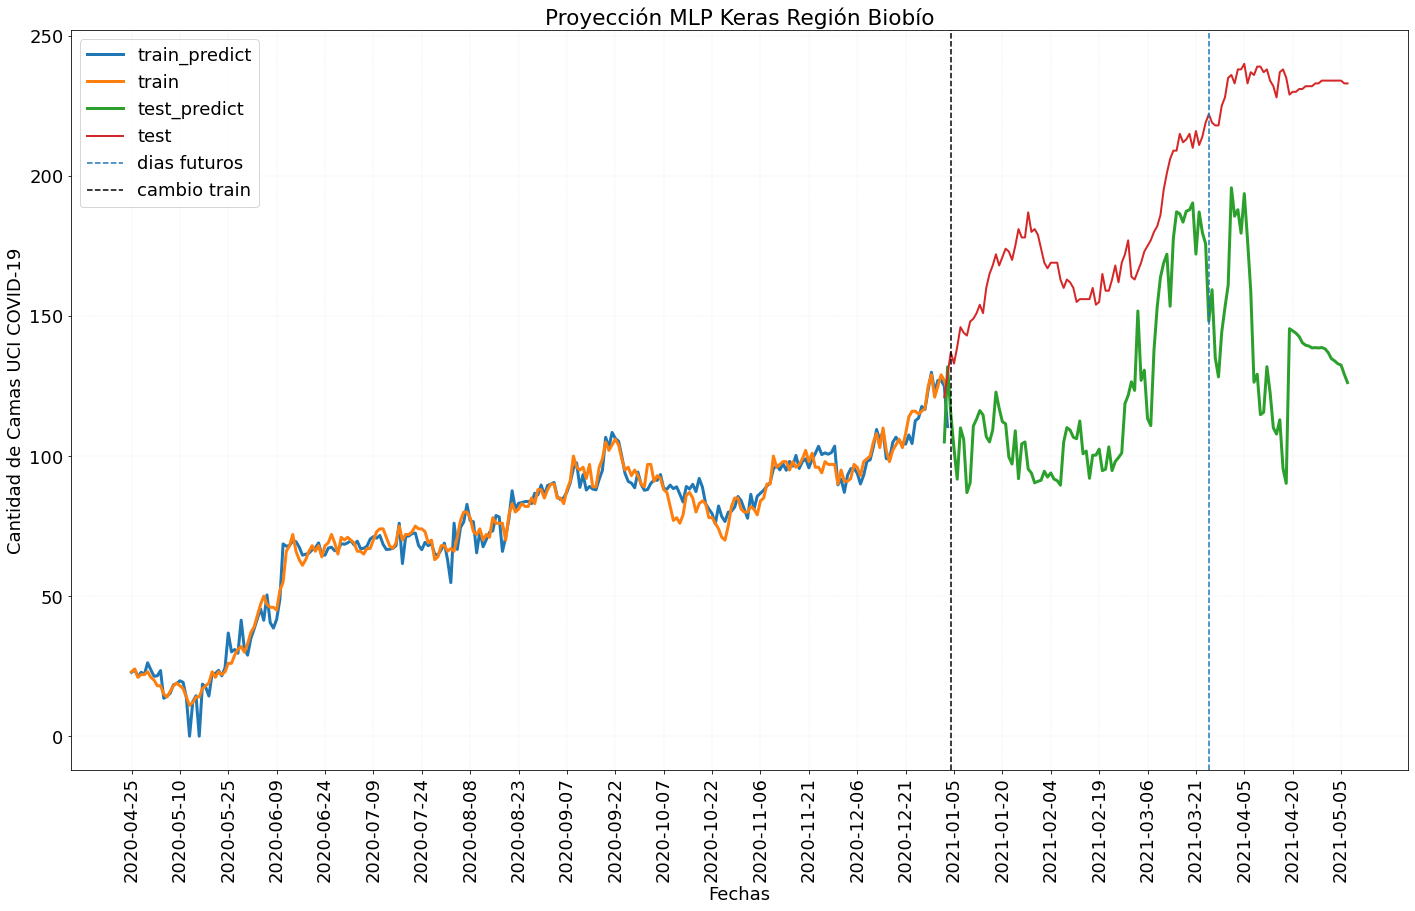

In [118]:
plt.figure(figsize=(20,13))
plt.plot(trainPredict,label="train_predict", linewidth =3)
plt.plot(y_train1,label="train",linewidth = 3)

puntos_base = np.arange(len(y_train1),len(y_train1)+len(y_test1),1)-2
plt.plot(puntos_base,testPredict,label="test_predict",linewidth = 3)
plt.plot(puntos_base,y_test1,label="test",linewidth = 2)
plt.xticks(np.arange(len(fechas))[::15],fechas[::15],rotation=90)
plt.axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.axvline(len(trainPredict),label="cambio train",linestyle="--",color="k")
plt.legend()
plt.xlabel('Fechas')
plt.ylabel('Cantidad de Camas UCI COVID-19')
plt.title('Proyección MLP Keras Región Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\resultados_perceptron_biobio.pdf')

In [71]:
# os.getcwd()

In [169]:
# model.save_weights("modelo_mlp_biobio_25_04.pkl")

#### G. LSTM

In [50]:
TIME_PERIODS = 3  # Periodo de Tiempos
STEP_DISTANCE =1   # Distancia
batch_size = 10    # Tamaño 
N_FEATURES =  X.shape[1]   # Cantidad de N

input_shape = (TIME_PERIODS*N_FEATURES)
input_shape

# Dividir entre train y test
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
Xtrain, Xtest = X[0:train_size,:], X[train_size:len(X),:]
ytrain, ytest = y[0:train_size], y[train_size:len(X)]
fechas_train,fechas_test =  fechas[0:train_size], fechas[train_size:len(X)]
X = Normalizer().fit_transform(X)

# Divide segmentos
x_train, y_train = create_segments_and_labels(Xtrain,
                                              ytrain,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

x_test, y_test = create_segments_and_labels(Xtest,
                                              ytest,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

NameError: name 'create_segments_and_labels' is not defined

In [120]:
# crear y ajustar el modelo Perceptrón Multicapa
lstm_model = Sequential()
lstm_model.add(LSTM(100,  input_shape=(x_train[0].shape), return_sequences=True))
lstm_model.add(LSTM(80 ))
lstm_model.add(Dense(100, activation='tanh'))
lstm_model.add(Dense(1, activation='relu'))
# print(lstm_model.summary())

In [121]:
# Entrenamiento
import tensorflow as tf
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
# lstm_model.load("modelo_mlp_biobio_final_1.pkl")
# history = lstm_model.fit(x_train, y_train, epochs=5000, batch_size=batch_size, verbose=2)

AttributeError: 'Sequential' object has no attribute 'load'

In [130]:
lstm_model = tf.keras.models.load_model("modelo_mlp_biobio_final_1.pkl")

In [124]:
# lstm_model = tf.keras.models.Sequential([

#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,input_shape=(x_train[0].shape), return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

In [125]:
# Grafica Optimizacion
plt.figure(figsize=(14,6))
plt.plot(history.epoch,history.history['loss'], color = 'blue', linewidth = 2)
plt.xlabel('épocas')
plt.ylabel('mse')
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.title('Optimizacion LSTM Región del Biobío')


plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\optimizador_lstm_biobio.pdf')

NameError: name 'history' is not defined

<Figure size 1008x432 with 0 Axes>

In [131]:
trainScore = lstm_model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 36608.27 MSE (191.33 RMSE)
Test Score: 6889.18 MSE (83.00 RMSE)


In [132]:
# Prediccion para entrenamiento
trainPredict = np.squeeze(lstm_model.predict(x_train))
testPredict  = np.squeeze(lstm_model.predict(x_test))

In [133]:
print("- r2_score", r2_score(y_test,testPredict))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test,testPredict)) 
print("- mean_squared_error", mean_squared_error(y_test,testPredict))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,testPredict))

print("{:.4f}".format(r2_score(y_test,testPredict))  ) #bondad del ajuste
print("{:.4f}".format(mean_absolute_error(y_test,testPredict)) )
print("{:.4f}".format( mean_squared_error(y_test,testPredict)))
print("{:.4f}".format(mean_absolute_percentage_error(y_test,testPredict)))

ValueError: y_true and y_pred have different number of output (1!=3)

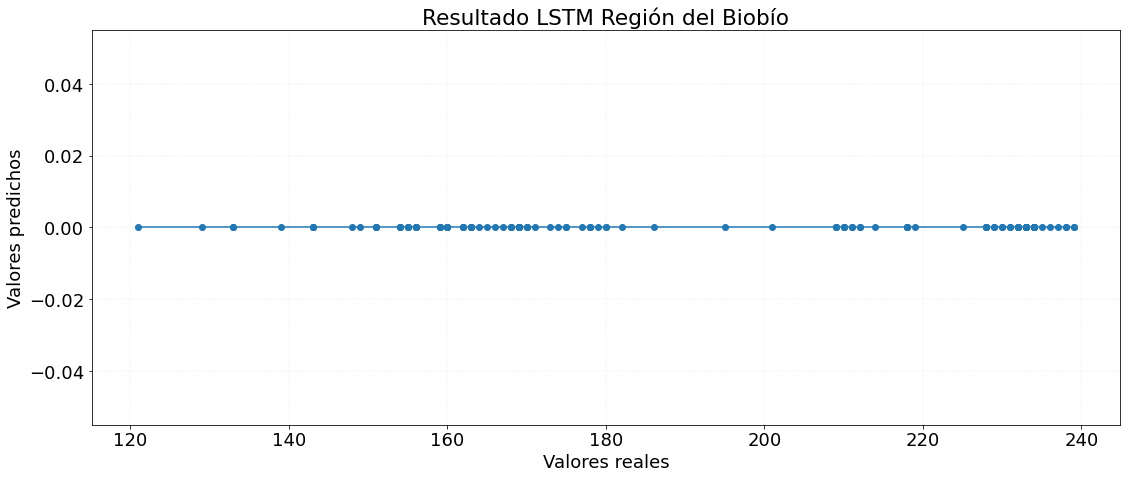

In [129]:
# Grafico Ajuste
plt.figure(figsize=(16,7))
plt.scatter(y_test,testPredict)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, testPredict, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.title('Resultado LSTM Región del Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\resultado_lstm_biobio.pdf')

In [270]:
# Formato Fecha
from datetime import datetime
fecha_hoy = '2021-03-26'
idx_fecha_hoy = np.argwhere(fechas_test==fecha_hoy)[0][0] + len(trainPredict)

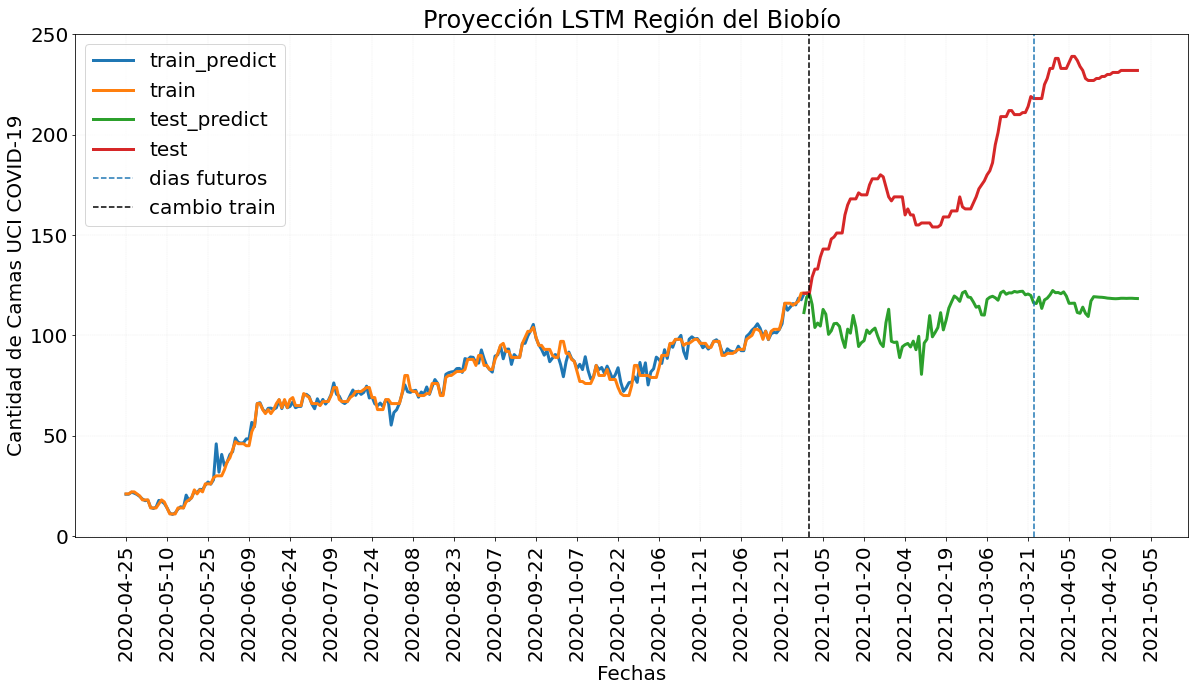

In [271]:
plt.figure(figsize=(17,10))
matplotlib.rcParams["font.size"]= 20

plt.plot(trainPredict,label="train_predict",linewidth = 3)
plt.plot(y_train,label="train",linewidth = 3)

puntos_base = np.arange(len(y_train),len(y_train)+len(y_test),1)-2
plt.plot(puntos_base,testPredict,label="test_predict", linewidth = 3)
plt.plot(puntos_base,y_test,label="test",linewidth = 3)
plt.xticks(np.arange(len(fechas))[::15],fechas[::15],rotation=90)
plt.axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.axvline(len(trainPredict),label="cambio train",linestyle="--",color="k")
plt.legend()
plt.xlabel('Fechas')
plt.ylabel('Cantidad de Camas UCI COVID-19')
plt.title('Proyección LSTM Región del Biobío')

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\proyeccion_lstm_biobio.pdf')

In [288]:
# model.save("modelo_mlp_biobio_final_1.pkl")

INFO:tensorflow:Assets written to: modelo_mlp_biobio_final_1.pkl\assets


## III. Grafico prediccion modelos

In [273]:
y_train.shape,y_test.shape

((250,), (123,))

In [274]:
X_train.shape

NameError: name 'X_train' is not defined

In [275]:
# Carga de los modelos
lstm_trainPredict = np.squeeze(lstm_model.predict(x_train))
lstm_testPredict  = np.squeeze(lstm_model.predict(x_test))

lstm_predict = np.concatenate([lstm_trainPredict,lstm_testPredict])

nn_trainPredict = np.squeeze(model.predict(x_train1))
nn_testPredict  = np.squeeze(model.predict(x_test1))
nn_predict = np.concatenate([nn_trainPredict,nn_testPredict])

tree_trainPredict = tree_reg.predict(np.squeeze(x_train1))
tree_testPredict = tree_reg.predict(np.squeeze(x_test1))
tree_predict = np.concatenate([tree_trainPredict,tree_testPredict])

lineal_trainPredict = reg.predict(np.squeeze(x_train1))
lineal_testPredict = reg.predict(np.squeeze(x_test1))
lineal_predict = np.concatenate([lineal_trainPredict,lineal_testPredict])

elasticnet_trainPredict = regr.predict(np.squeeze(x_train1))
elasticnet_testPredict = regr.predict(np.squeeze(x_test1))
elasticnet_predict = np.concatenate([elasticnet_trainPredict,elasticnet_testPredict])

mlp_trainPredict = mlp.predict(np.squeeze(x_train1))
mlp_testPredict = mlp.predict(np.squeeze(x_test1))
mlp_predict = np.concatenate([mlp_trainPredict,mlp_testPredict])

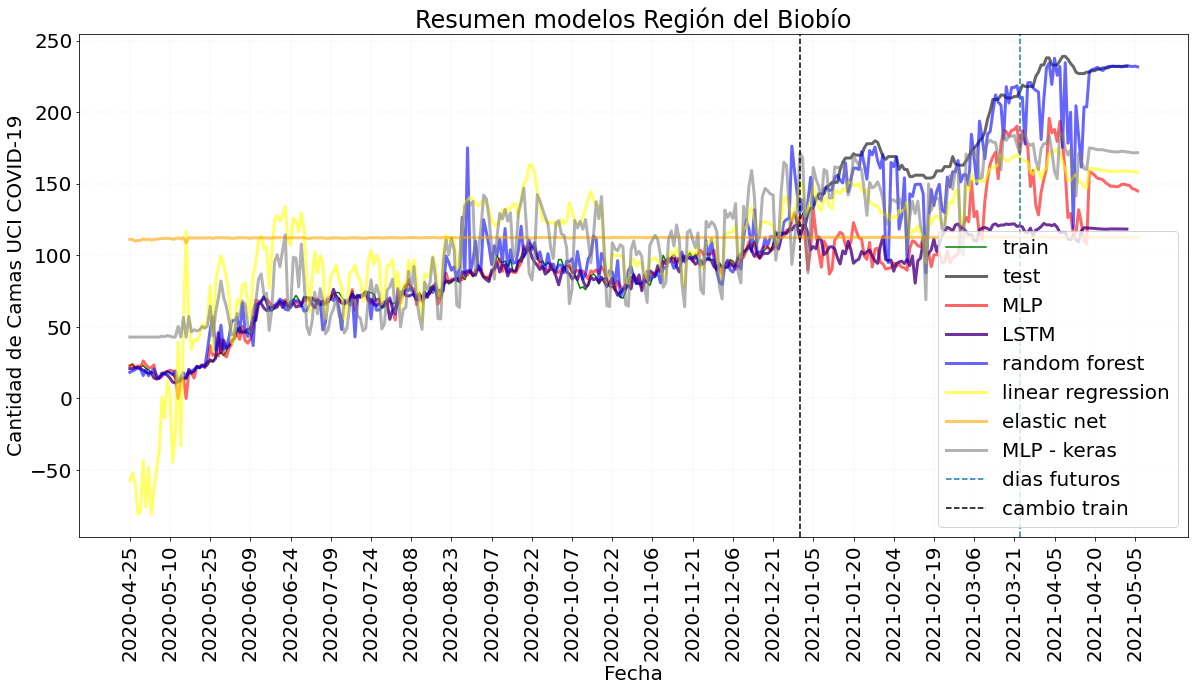

In [276]:
plt.figure(figsize=(17,10))
matplotlib.rcParams["font.size"]= 20

puntos_base = np.arange(len(y_train),len(y_train)+len(y_test),1)
plt.plot(y_train1,label="train", color = 'green')
plt.plot(puntos_base,y_test,label="test", color = 'black', alpha = 0.6, linewidth = 3)


plt.plot(nn_predict,label="MLP",color = 'red', alpha = 0.6, linewidth = 3)
plt.plot(lstm_predict,label="LSTM", color = 'indigo', alpha = 0.8, linewidth = 3)
plt.plot(tree_predict,label="random forest", color = 'blue', alpha = 0.6, linewidth = 3)
plt.plot(lineal_predict,label="linear regression",  color = 'yellow', alpha = 0.6, linewidth = 3)
plt.plot(elasticnet_predict,label="elastic net",  color = 'orange', alpha = 0.6, linewidth = 3)
plt.plot(mlp_predict,label="MLP - keras", color = 'gray', alpha = 0.6, linewidth = 3)

plt.xticks(np.arange(len(fechas))[::15],fechas[::15],rotation=90)
plt.axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
plt.axvline(len(trainPredict),label="cambio train",linestyle="--",color="k")
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Camas UCI COVID-19')
plt.title('Resumen modelos Región del Biobío')
plt.legend()

plt.tight_layout()
plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\resumen_biobio.pdf')

In [74]:
predicciones = [
# (nn_predict,"MLP-keras"),
# (lstm_predict,"LSTM"),
# (tree_predict,"random forest"),
# (lineal_predict,"linear regression"),
(elasticnet_predict,"elastic net")
    
# (mlp_predict,"MLP-sklearn")
]

In [125]:
puntos_base = np.arange(len(y_train),len(y_train)+len(y_test),1)
matplotlib.rcParams["font.size"]= 25
fig, axs = plt.subplots(3, 2, figsize=(42,28))
axs = axs.flatten()
for idx,(prediccion,modelo) in enumerate(predicciones):
    axs[idx].plot(y_train,label="train", color = 'red')
    axs[idx].plot(puntos_base,y_test,label="test", color = 'blue', alpha = 0.6)
    axs[idx].axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
    axs[idx].axvline(len(trainPredict),label="cambio train",linestyle="--",color="k")
    axs[idx].axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
    axs[idx].axvline(len(trainPredict),label="cambio train",linestyle="--",color="k")
    axs[idx].set_title(modelo)
    axs[idx].plot(prediccion,label=modelo,color = 'red', alpha = 0.6)
    axs[idx].legend()
# plt.legend()
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.tight_layout()
# plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\resumen2_biobio.pdf')

NameError: name 'y_train' is not defined

In [76]:
# Formato Fecha
from datetime import datetime
fecha_hoy = '2021-03-26'
idx_fecha_hoy = np.argwhere(fechas_test==fecha_hoy)[0][0] + len(trainPredict)

NameError: name 'trainPredict' is not defined

In [102]:
elasticnet_trainPredict = regr.predict(np.squeeze(x_train1))
elasticnet_testPredict = regr.predict(np.squeeze(x_test1))
elasticnet_predict = np.concatenate([elasticnet_trainPredict,elasticnet_testPredict])

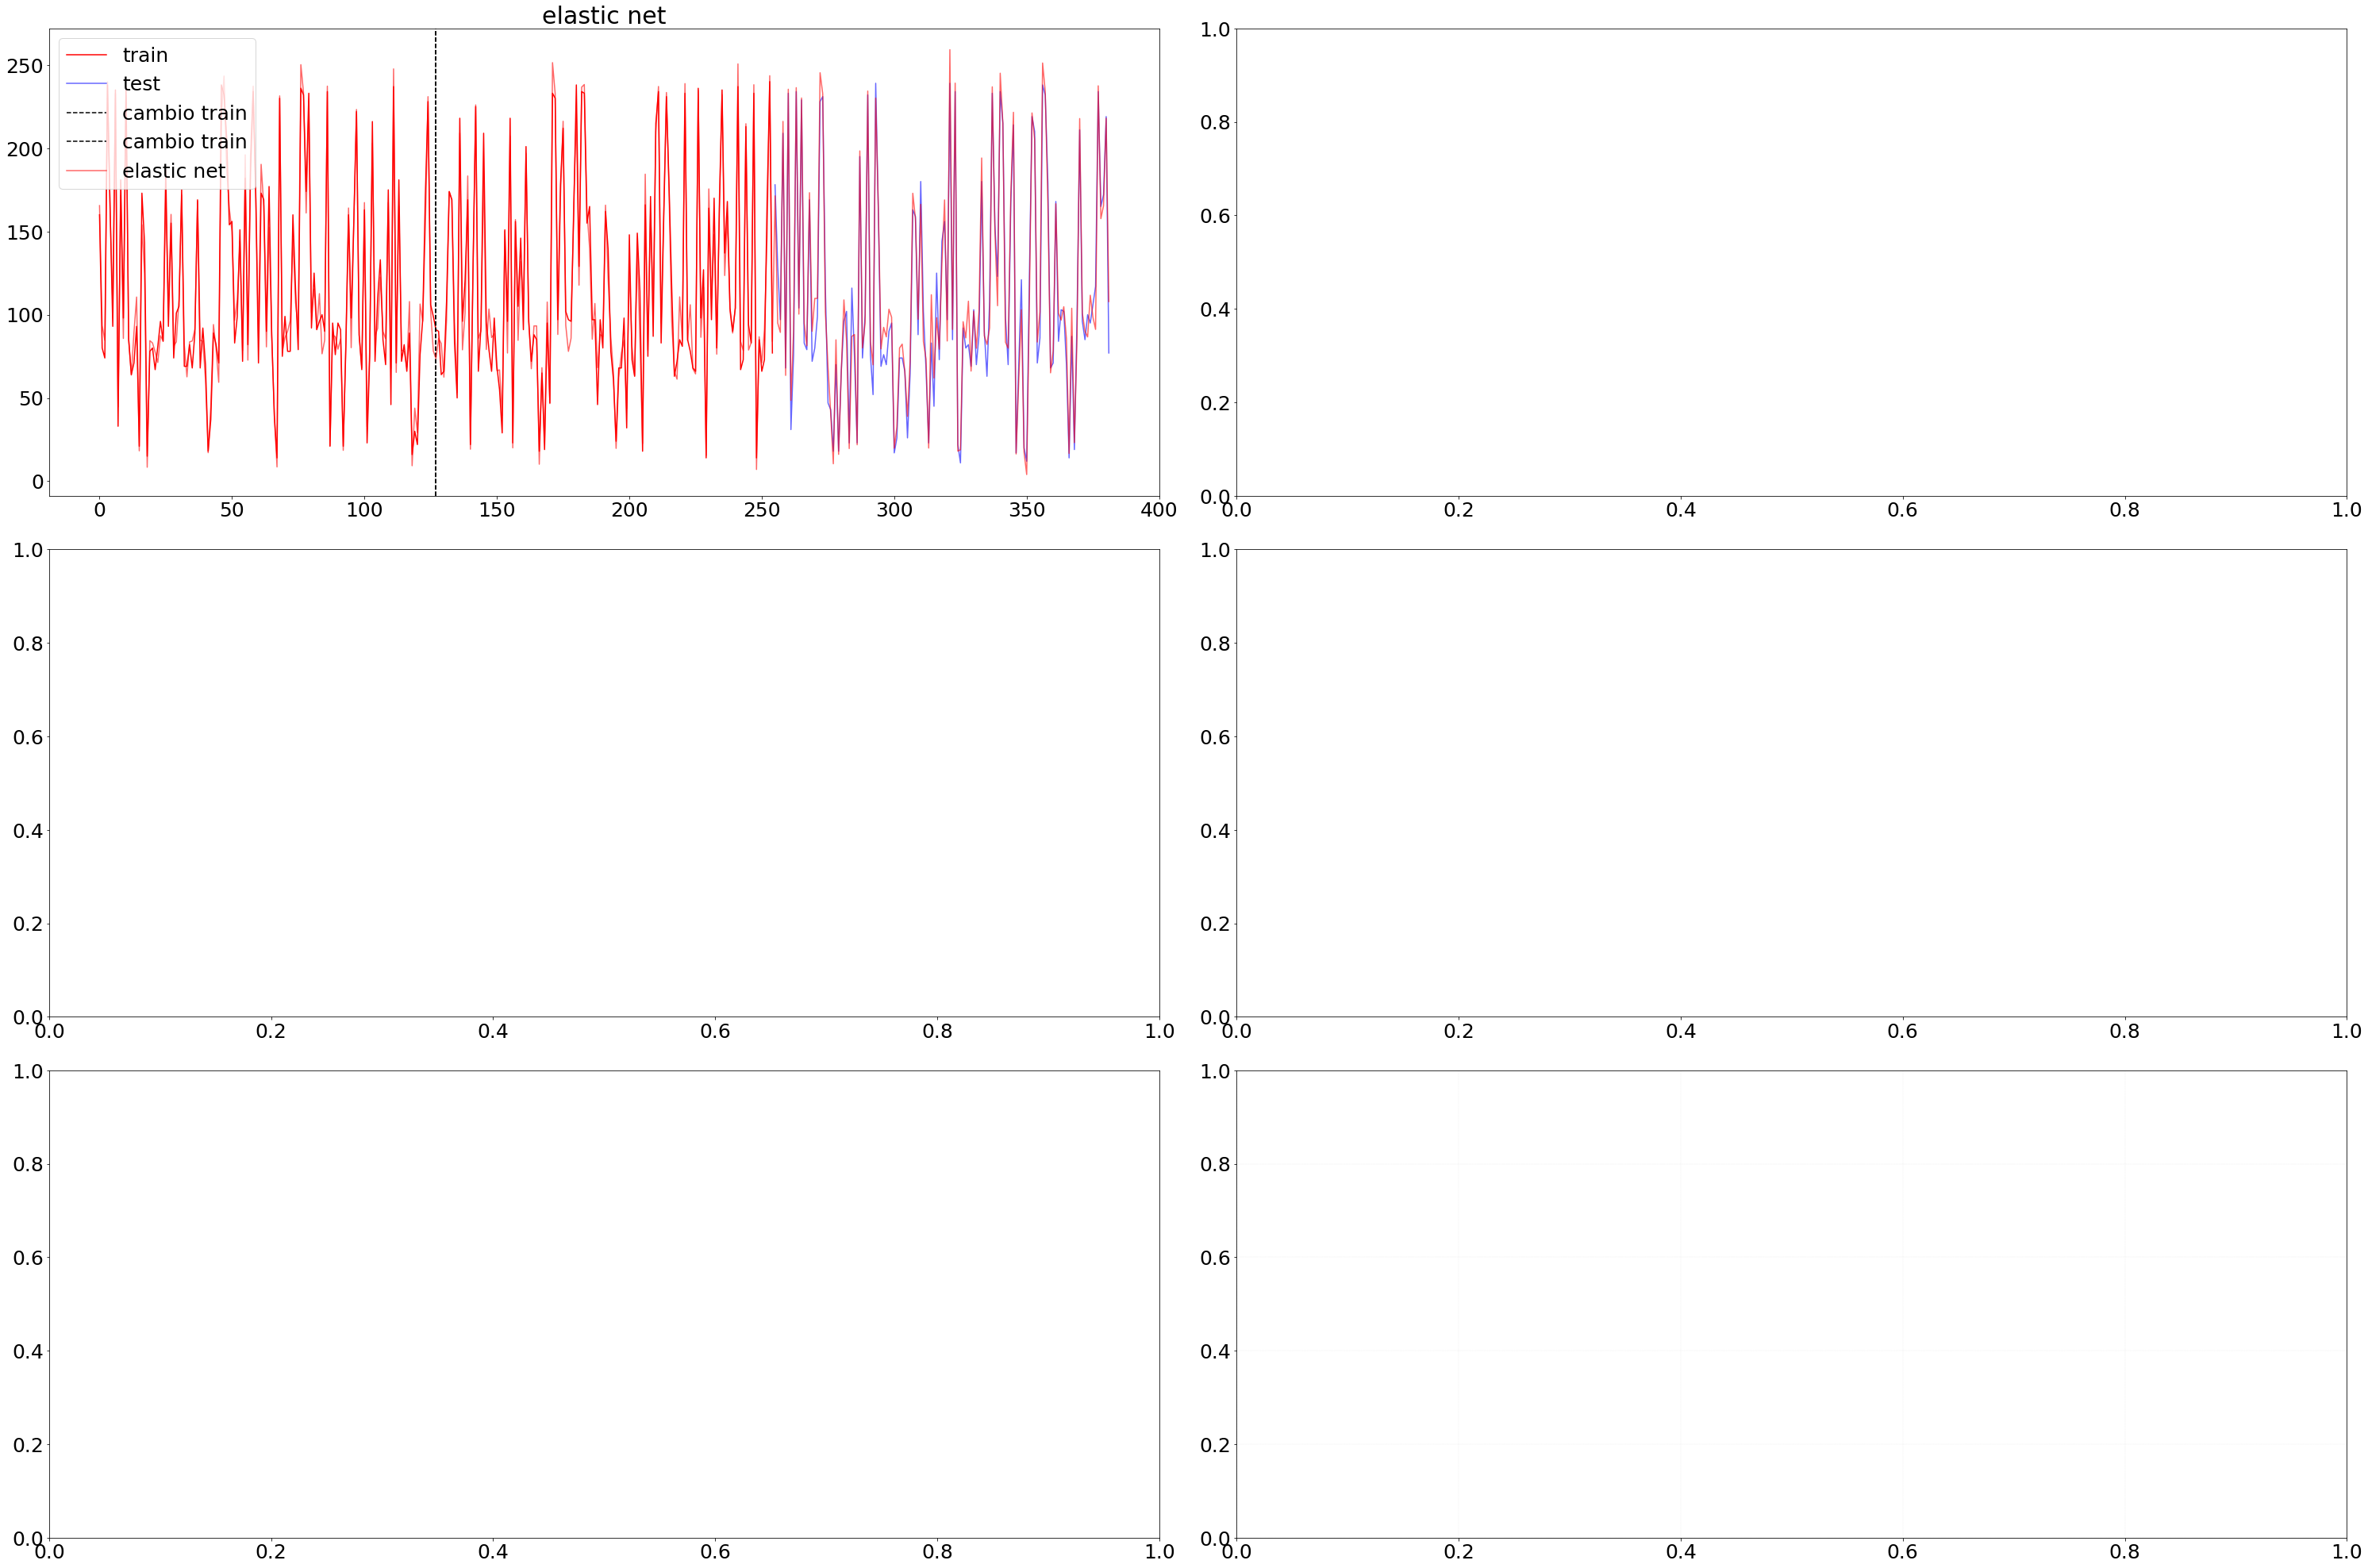

In [132]:
puntos_base = np.arange(len(y_train1),len(y_train1)+len(y_test1),1)
matplotlib.rcParams["font.size"]= 25
fig, axs = plt.subplots(3, 2, figsize=(42,28))
axs = axs.flatten()
for idx,(prediccion,modelo) in enumerate(predicciones):
    axs[idx].plot(y_train1,label="train", color = 'red')
    axs[idx].plot(puntos_base,y_test1,label="test", color = 'blue', alpha = 0.6)
#     axs[idx].axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
    axs[idx].axvline(len(y_pred1),label="cambio train",linestyle="--",color="k")
#     axs[idx].axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
    axs[idx].axvline(len(y_pred1),label="cambio train",linestyle="--",color="k")
    axs[idx].set_title(modelo)
    axs[idx].plot(prediccion,label=modelo,color = 'red', alpha = 0.6)
    axs[idx].legend()
# plt.legend()
plt.grid(color='lightgrey', ls = '-.', lw = 0.2)
plt.tight_layout()

plt.savefig(r'E:\Udec\Magister\Tesis\Modelo\Datos de entrada\figuras\resumen2_biobio1.pdf')